# Week 2 ‒ 모두의 주차장 데이터를 이용해서 이용자별 향후 이용 건수 예측하기

## 프리온보딩 코스 1기 4팀 모두의 주차장 데이터 분석

#### 발표자 박찬서, 황낙주

## 문제 정의
- 목표 : 이용자 별 결제 이력을 바탕으로 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
- 예측 과제 : 이용자 별 한 향후 한 달간 이용 건수를 예측하는 Regression 문제 (평가 메트릭 : MSE, MAE)
- 데이터 : 2020.01.01 ~ 2020.12.31 기간에 대한 유저가입정보(유저ID, 가입일), 소비행동정보(상품ID, 점포주소, 결제일, 결제건수), 외부정보(서울시 교통량 데이터, 기상 데이터)

## 주어진 데이터의 컬럼 정보를 활용한 초기 가설 수립
- 가입일 : 가입한지 오래된 유저일수록 앱 사용이 익숙해서 서비스를 더 빈번하게 이용할 것이다.
- 상품/결제ID : 티켓(goods_type) 혹은 결제타입(d_type)별로 유저가 느끼는 만족도가 달라서 어떤 티켓을 주로 사용하는 유저인지에 따라 서비스 이용 빈도가 다를 것이다.
- 점포주소 : 주차장 위치, 특성에 따라 유저가 느끼는 만족도가 달라서 어느 곳의 주차장을 주로 이용하는 유저인지에 따라 서비스 이용 빈도가 다를 것이다.
- 결제일 : 주말보다 주중 결제 건이 많은 유저들은 업무와 관련된 주차 수요가 있어서 서비스를 더 빈번하게 이용할 것이다.
- 최고기온 : 너무 덥거나 추운 날일수록 더 편리하게 주차하고 싶어하는 수요가 많을 것이다.
- 불쾌지수 : 불쾌지수가 높은 날일수록 더 편리하게 주차하고 싶어하는 수요가 많을 것이다.

 ➡️ <b>EDA를 통해 가설을 검증하고, 유의미한 변수를 추려내어 이용자별 이용 건수를 예측하는 모델링 진행


## 📄 목차

0. 데이터 불러오기
1. data description
2. 결측치, 이상치
3. feature engineering
4. EDA
5. 모델링

## ✅ 요약 

- EDA
    + 유저의 성향에 따라 구매 유도를 다르게 해야한다.
    + 재구매(2번 째 결제)를 유도해서 고객의 단기 이탈률을 줄이는 서비스 개선이 필요하다.
    
- 모델링
    + 유저별 특성을 잡아낼 수 있는 피쳐엔지니어링 컬럼을 활용한다.
    + 유저별 & 월별 groupby한 데이터셋을 사용했을 때 더 많은 인사이트 도출이 가능해 보인다.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
#plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

pd.options.display.float_format = '{:20,.0f}'.format
pd.options.display.max_columns = 99
np.random.seed(42)

In [3]:
df = pd.read_csv('실전db.csv', encoding='cp949')

In [4]:
df = df.rename(columns=str.lower)

In [5]:
df.describe()

,user_id,store_id,count
count,"879,271","879,271","879,271"
mean,"1,206,566","149,600",1
std,"420,653","68,898",1
min,224,4,1
25%,"900,576","92,437",1
50%,"1,321,440","173,059",1
75%,"1,542,416","220,661",1
max,"1,830,598","231,465",61


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     879271 non-null  int64 
 1   join_date   879271 non-null  object
 2   d_type      879271 non-null  object
 3   store_id    879271 non-null  int64 
 4   goods_type  879271 non-null  object
 5   date        879271 non-null  object
 6   count       879271 non-null  int64 
 7   ad1         879271 non-null  object
dtypes: int64(3), object(5)
memory usage: 53.7+ MB


In [7]:
df.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


<br><br>
## 🚙 Step 1. data 정확히 이해하기

#### ⚠️ categorical 변수들에 대해서는 제대로 설명이 되어 있지 않음

### 📋주어진 Data Description

1. user_id : 유저 ID
2. join_date : 가입일
3. d_type : 
4. store_id : 점포 주소
5. goods_type :
6. date : 결제일
7. count : 결제건수
8. ad1 : 

🚙 **데이터와 모두의 주차장 앱을 서칭하며 비어있는 data description을 파악해보자**

##### 1. d_type

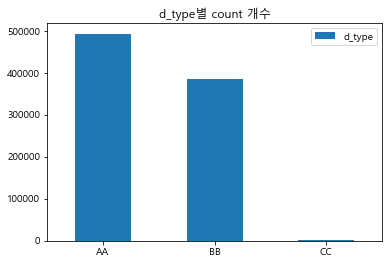

In [8]:
# d_type별 count개수
countbytypes = pd.DataFrame(df['d_type'].value_counts())
countbytypes.plot(kind = 'bar', title = 'd_type별 count 개수', rot = 0);

In [9]:
df['d_type'].value_counts()

AA    493166
BB    384541
CC      1564
Name: d_type, dtype: int64

In [10]:
# d_type이 user_id에 1:1 대응되는 모습
df.groupby('user_id')['d_type'].value_counts()

user_id  d_type
224      AA         2
232      BB        23
342      AA         1
565      AA         2
729      AA         1
                   ..
1830551  BB         1
1830570  BB         1
1830580  AA         1
1830589  BB         1
1830598  AA         1
Name: d_type, Length: 165425, dtype: int64

In [11]:
# d_type이 store_id에 n:m 대응되는 모습
df.groupby('store_id')['d_type'].value_counts()

store_id  d_type
4         AA        13
          BB        12
8         BB        28
          AA        19
161       BB         3
                    ..
231444    AA         1
231453    AA        14
          BB         8
231465    AA        10
          BB         4
Name: d_type, Length: 2272, dtype: int64

##### 2. goods_type

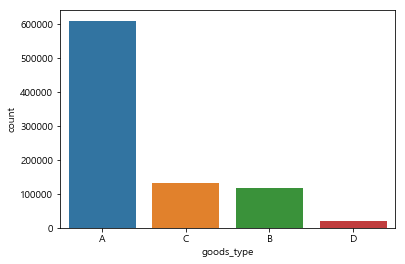

In [12]:
# goods_type 개수
sns.countplot(x = "goods_type", data = df)
plt.show()

In [13]:
df['goods_type'].value_counts()

A    609790
C    131163
B    118541
D     19777
Name: goods_type, dtype: int64

In [14]:
# goods_type의 패턴 : 주기성 확인
df.groupby(['date', 'goods_type']).size().unstack(fill_value=0).loc['2020-01-01':'2020-01-31',:]

goods_type,A,B,C,D
date,,,,
2020-01-01,661,34,210,19
2020-01-02,921,304,197,56
2020-01-03,905,505,268,46
2020-01-04,1553,144,454,37
2020-01-05,1065,56,351,27
2020-01-06,950,276,192,45
2020-01-07,1021,347,225,33
2020-01-08,997,437,195,33
2020-01-09,988,433,255,42


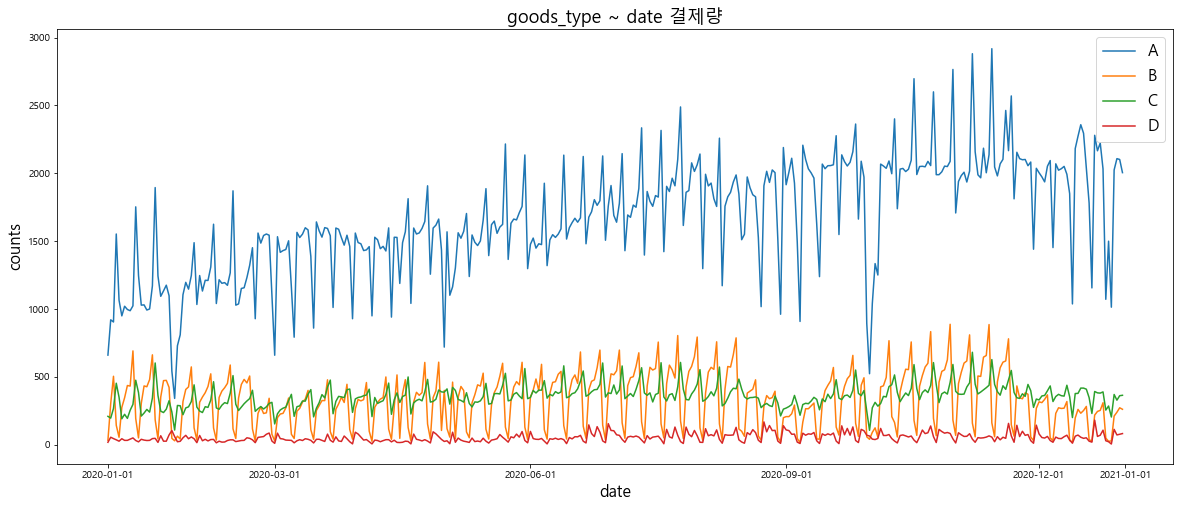

In [15]:
# goods_type 별 결제량 시각화
countbydate = df.groupby(['date', 'goods_type']).size().unstack(fill_value=0)

plt.figure(figsize=(20,8))
sns.lineplot(countbydate.index, countbydate['A'])
sns.lineplot(countbydate.index, countbydate['B'])
sns.lineplot(countbydate.index, countbydate['C'])
sns.lineplot(countbydate.index, countbydate['D'])

plt.legend(['A', 'B', 'C', 'D'], loc='best', fontsize=16)
plt.title('goods_type ~ date 결제량', fontsize=18)
plt.ylabel('counts', fontsize=16)
plt.xlabel('date', fontsize=16)
plt.xticks(ticks = ['2020-01-01', '2020-03-01', '2020-06-01', '2020-09-01', '2020-12-01', '2021-01-01'])
plt.show()


##### 3. ad1

In [16]:
# 85개 ad1 값 확인
df['ad1'].unique()

array(['GN', 'J', 'SC', 'MP', 'JRR', 'YD', 'GJ', 'YO', 'GSN', 'GBC', 'BF',
       'DJ', '0', 'CD', 'NO', 'CY', 'YC', 'SD', 'GD', 'GSW', 'DM', 'R',
       'GB', 'GS', 'GHN', 'SB', 'IND', 'P', 'GW', 'JR', 'GEJ', 'GGY',
       'GKP', 'CAS', 'SG', 'BJG', 'BHW', 'GAY', 'GYI', 'CCA', 'PJP',
       'GGC', 'IYS', 'DB', 'GGM', 'GAS', 'WOID', 'DIV', 'AOI', 'COI',
       'GPJ', 'SOI', 'ABP', 'DOI', 'WF', 'BI', 'ZP', 'EP', 'Q', 'BO',
       'ZE', 'RRR', 'QGI', 'DSO', 'SOD', 'BOI', 'WT', 'BP', 'SP', 'CN',
       'SJV', 'SDU', 'QH', 'BUD', 'CU', 'VU', 'WAE', 'NW', 'DY', 'WH',
       'GR', 'X', 'CVB', 'ADS', 'VO'], dtype=object)

<br><br>
### 📋 Data description 재정의

|변수명|정의|값|
|:---:|:---:|:---|
|user_id|유저 ID||
|join_date|가입일||
|d_type|**결제 수단**|AA : 카드 결제<br>BB : 네이버 페이<br>CC : 휴대폰 결제|
|store_id|점포 주소||
|goods_type|**판매 주차권**|A : 모든 종류의 평일 주간 주차권<br>B : 모든 종류의 평일 야간 주차권<br>C : 모든 종류의 주말 주간 주차권<br>D : 모든 종류의 주말 야간 주차권|
|date|결제일||
|count|결제 건수||
|ad1|**지역 코드**|예) GN : 강남, MP : 마포 ...|

<br>

* goods_type 분류 표

|goods_type|주간|야간|
|---|---|---|
|평일|A|B|
|주말|C|D|

* 지역 코드 ad1의 경우, 함께 주어진 외부 데이터(교통량, 기상 데이터)가 서울시 중심이라 서울 지역을 세분화한 코드라고 예측

❗️ **회의를 통해 가장 가능성이 높은 설명을 붙였으며, 정의를 단정짓기는 어려움**


<br><br>
## 🚫 Step 2. 결측치, 이상치 확인

+ 결측치 : 없음
+ 이상치 : 
 - join_date == '1970-01-01'
     <br>가입 날짜가 1970-01-01로 찍힌 버그가 존재하므로 제거한다.
 - user_id == 999665
     <br>user_id가 999665 데이터는 비상식적인 결제량 정보를 담고 있다.
     <br>사용내역이 작년 한 해 366일 매일 존재했고 count값도 크다. 
     <br>회원 정보에 대한 데이터가 없어서 자세한 판단은 불가능하지만, 직원 공용 아이디로 추측해본다.

In [17]:
# Unix time error
df[(df['join_date'] == '1970-01-01')].sort_values(by = 'count', ascending = False)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
368711,1277650,1970-01-01,CC,92264,C,2020-06-26,4,JRR
269797,851134,1970-01-01,CC,190482,A,2020-05-17,3,GN
71522,1493307,1970-01-01,CC,82433,D,2020-02-10,3,CY
590435,1661920,1970-01-01,CC,109877,C,2020-09-18,2,GN
139409,654237,1970-01-01,CC,181777,C,2020-03-17,2,BF
...,...,...,...,...,...,...,...,...
175767,654237,1970-01-01,CC,181777,C,2020-04-03,1,BF
176320,1071641,1970-01-01,CC,221045,A,2020-04-03,1,GN
176853,1355917,1970-01-01,CC,220700,A,2020-04-03,1,GN
176971,1415023,1970-01-01,CC,131081,A,2020-04-03,1,YO


In [18]:
# user_id 999665의 연간 결제횟수 7919건
df_user = df.groupby('user_id')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_user

,user_id,count
44115,999665,7919
100781,1514190,284
16448,591610,245
90227,1467323,239
76230,1355841,235
...,...,...
45671,1023974,1
110166,1551355,1
45674,1024027,1
45676,1024047,1


In [19]:
# 매일 사용내역이 여러건 조회됨. 직원 공용 아이디로 추측
df[df['user_id'] == 999665]

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN
...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS


In [20]:
df = df[(df['join_date'] != '1970-01-01')]
df = df[df['user_id'] != 999665]

<br><br><br>
## 🔧 Step 3. Feature Engineering 진행

- 1. 외부데이터인 '서울시_기상데이터.csv'를 이용하여 count와 관계가 있을 만한 변수를 가져온다.
- 2. 주어진 데이터의 기본 변수에서 새로운 컬럼을 추가한다.


#### ✅Feature Engineering 을 진행하기 전 먼저 train과 test 데이터를 분류해준다.

In [21]:
# train, test
train = df[df.date <= '2020-09-30']
test = df[df.date > '2020-09-30']
display(train, test)

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
623574,1709914,2020-09-30,BB,221022,B,2020-09-30,1,GN
623575,1709935,2020-09-30,AA,725,B,2020-09-30,1,MP
623576,1709942,2020-09-30,AA,223058,B,2020-09-30,1,BF
623577,1709950,2020-09-30,BB,182320,A,2020-09-30,2,JRR


,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
623579,15521,2014-09-12,AA,182320,A,2020-10-01,1,JRR
623580,17651,2014-09-19,BB,82434,D,2020-10-01,1,J
623581,26388,2014-10-25,BB,182320,A,2020-10-01,1,JRR
623582,81772,2015-05-02,BB,204438,A,2020-10-01,1,DJ
623583,92258,2015-05-24,AA,220745,A,2020-10-01,1,SD
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


#### 1. 외부 데이터 Feature Engineering

1) 기상 데이터

In [22]:
weather_data = pd.read_csv('서울시_기상데이터.csv', encoding='cp949')
weather_data.dtypes

지점        int64
일시       object
기온      float64
강수량     float64
풍속      float64
습도        int64
일조시간    float64
적설량     float64
지면온도    float64
지중온도    float64
dtype: object

In [23]:
# 데이터 기본 전처리
weather_data['일시'] = weather_data['일시'].astype('datetime64')
weather_data['date'] = weather_data['일시'].dt.date

# 날씨 데이터의 `기온` 컬럼에서 8월 26일 13시 데이터 하나가 결측치로 잡혀있다. 
# 이 부분은 12시 데이터와 14시 데이터를 참고하여 34℃로 삽입했다.
weather_data['기온'] = weather_data['기온'].fillna(34)
weather_data = weather_data.fillna(0)

In [24]:
# 일 최고기온과 누적강수량, 불쾌지수를 구하는 weather_max
weather_data['누적강수량'] = weather_data.groupby('date')['강수량'].cumsum()
weather_data['discomfort'] = (0.81 * weather_data['기온']) + (0.01*weather_data['습도']*(0.99*weather_data['기온']-14.3)) + 46.3
weather_max = weather_data.groupby('date').max().reset_index()

# 누적강수량 15mm를 기준으로 [강한비, 약한비, 해당없음, 눈온날] 로 구분하는 extreme_weather
weather_max['extreme_weather'] = np.where(weather_max["적설량"].values > 0, '눈', np.where(weather_max["누적강수량"].values > 15, '강한비', np.where(weather_max["누적강수량"].values > 0, '약한비', '없음')))

# 날씨 데이터 12월 31일 데이터에는 00시 날씨 정보만 삽입되어 있기 때문에 최고 기온을 고쳐준다.  
weather_max.loc[365, '기온'] = -5

# 불쾌지수를 그룹핑해주는 discomfort_index
weather_max['discomfort_index'] = np.where(weather_max["discomfort"].values > 80, '매우불쾌', np.where(weather_max["discomfort"].values > 70, '불쾌', '쾌적'))

# 변수명을 최고기온으로 맞춰주고, date의 type을 시간데이터로 맞춰서 머지
weather_max = weather_max.rename(columns = {'기온': 'max_temp'}, inplace = False)
weather_max = weather_max[['date', 'max_temp', 'discomfort_index', 'extreme_weather']]
df['date'] = df['date'].astype('datetime64')
weather_max['date'] = weather_max['date'].astype('datetime64')
df = pd.merge(df, weather_max, how = 'left', on = 'date')

2) 교통량 데이터

In [25]:
traffic = pd.read_excel('2020교통량통합.xlsx')

In [26]:
# 일별 교통량 합계 구하기
traffic['traffic_sum'] = traffic.loc[:,'0시':'23시'].sum(axis = 1)
traffic_grouped = traffic.groupby('DATE')['traffic_sum'].sum().reset_index().rename(columns = {'DATE' : 'date'})
df_temp = df.groupby('date')['count'].sum().reset_index()
df_traffic = traffic_grouped.merge(df_temp, how = 'outer', on = 'date')

# df 데이터셋에 교통량 변수 머지
df = df.merge(df_traffic, how = 'outer', on = 'date').drop('count_y', axis = 1).rename(columns = {'count_x' : 'count'})

#### 2. 기본 변수에 대한 Feature Engineering

In [27]:
# 기본 날짜 데이터 쪼개기
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['week'] = df['date'].dt.isocalendar().week

# 공휴일 추가
df['isholiday'] = df['date'].isin(['2020-01-01', '2020-01-24', '2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25'])

# 몇개월차 유저인가
df['join_date'] = df['join_date'].astype('datetime64')
df['howlonguser'] = (df['year']*12 + df['month']) - (df['join_date'].dt.year*12 + df['join_date'].dt.month) + 1

In [28]:
# 해당 날짜까지의 누적 카운트를 구하는 freq_cum과 활성화 정도를 보여주는 active를 구하기 위한 코드

# 누적 결제 횟수
df_l = df.sort_values(['user_id','date']).reset_index(drop=True)
df_l['next'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(-1)
df_l['before'] = df_l.sort_values(['user_id','date']).groupby('user_id')['date'].shift(1)
df_l['freq_cum'] = pd.DataFrame(df_l.groupby(['user_id','date'])['before'].count()).groupby('user_id')['before'].cumsum().values
df_l['ranking'] = np.where(df_l["freq_cum"].values <= 1 , '브론즈', np.where(df_l["freq_cum"].values <= 5 , '실버', np.where(df_l["freq_cum"].values <= 18 , '골드', '플래티넘')))

In [29]:
# ranking을 분류하는 기준은 누적 카운트의 통계량을 기준으로 정했음
df_l['freq_cum'].describe()

count                877,812
mean                      15
std                       24
min                        0
25%                        1
50%                        5
75%                       18
max                      243
Name: freq_cum, dtype: float64

In [30]:
# 활성화 정도를 보여주는 active를 구하기
# 주의할 점 : active는 현시점(2020-12-31)을 기준으로 고객을 분류하기 때문에 EDA에서만 사용하고 모델링에서는 반드시 제거해줘야함

df_l['comeback'] = (pd.to_datetime('2020-12-31') - df_l['date']).dt.days

# 최근 결제 날짜
www = pd.DataFrame(df_l.groupby(['user_id'])['comeback'].min()).reset_index()
www = www.rename(columns = {'comeback': 'min_cb'}, inplace = False)

# 최대 누적 카운트
eee = pd.DataFrame(df_l.groupby(['user_id'])['freq_cum'].max()).reset_index()
eee = eee.rename(columns = {'freq_cum': 'max_freq'}, inplace = False)

df_cb = pd.merge(www, eee, how = 'left', on = 'user_id')
df_l = pd.merge(df_l, df_cb, how = 'left', on = ['user_id'])
df_l['active'] = np.where(df_l['min_cb'] <= 31, '활성유저', np.where(df_l['max_freq'] >= 5, '잠수유저', '비활성유저'))

In [31]:
# freq_cum과  active를 df에 머지
freqbyuser = df_l[['user_id', 'date', 'freq_cum', 'ranking', 'active']]
df = pd.merge(df, freqbyuser, how = 'left', on = ['user_id', 'date'])

####################### howlonguser를 기준으로 고객 등급 매기기
df['howlong'] = np.where(df['howlonguser'] <= 3, '1~3', np.where(df['howlonguser'] <= 6, '3~6', np.where(df['howlonguser'] <= 12, '6~12', np.where(df['howlonguser'] <= 24, '1년차', '2년 이상'))))

In [32]:
# 각 그룹에 대한 데이터는 균형있게 들어갔는지 확인
df['ranking'].value_counts()

브론즈     255588
골드      218012
플래티넘    216979
실버      187233
Name: ranking, dtype: int64

In [33]:
df['active'].value_counts()

활성유저     380526
잠수유저     294942
비활성유저    202344
Name: active, dtype: int64

In [34]:
df['howlong'].value_counts()

1~3      219630
2년 이상    201190
1년차      187005
6~12     156922
3~6      113065
Name: howlong, dtype: int64

<br><br>
#### 🔧Feature Engineering 내용 정리

1. 주어진 서울시 기상데이터 csv 파일로 `max_temp`, `extreme_weather`, `discomfort_index` 변수를 추가했다.
    - max_temp : 일 최고 기온
    - extreme_weather : 날씨 구분 (눈, 약한비, 강한비, 해당없음)
    - discomfort_index : 불쾌지수 구분 (매우불쾌, 불쾌, 쾌적)
<br> 주어진 데이터에서 기온 값에 하나의 NA값이 존재하는데, max의 영향을 받지 않을 정도의 숫자 34를 임의로 집어넣었다.
<br> 또한 12월 31일 날짜에는 00시 데이터만 있다. 해당 날짜의 일 최고 기온은 아래 링크를 참고하여 데이터를 삽입했다.<br>  https://www.weather.go.kr/weather/climate/past_cal.jsp?stn=108&yy=2020&mm=12&x=20&y=5&obs=1
<br><br>
2. 주어진 교통량 데이터 xlsx 파일로 일별 교통량 합계인 `traffic_sum` 변수를 만들었다.
<br><br>
3. date 변수를 연, 월, 일자, 날짜, 주차로 쪼개서 저장하여 각각 `year`, `month`, `day`, `weekday`, `week`의 변수를 추가했다.
<br><br>
4. (결제년월 - 가입년월)로 몇 개월차 유저인지 파악하는 변수 `howlonguser`를 만들었다.
<br><br>
5. `howlonguser`를 바탕으로 유저가 가입한 지 얼마나 오래됐는지를 나타내는 `howlong` 변수를 만들었다.
    - 1~3 : 가입일이 3개월 이내인 유저
    - 3~6 : 가입일이 6개월 이내인 유저
    - 6~12 : 가입일이 1년 이내인 유저
    - 1년차 : 1년차 유저
    - 2년 이상 : 가입 2년 이상 고인물 유저
<br><br>
6. 국가 공휴일 데이터인 `isholiday` 변수를 추가했다. 다음의 사이트를 참고하였다.<br>
https://publicholidays.co.kr/ko/2020-dates/
<br><br>
7. 누적 결제를 카운트하는 `freq_cum`을 만들고 `freq_cum`의 통계량을 바탕으로 회원 등급을 매기는 `ranking` 컬럼을 만들었다.
    - 브론즈 : 0 ~ 1회
    - 실버 : 2 ~ 5회
    - 골드 : 6 ~18회
    - 플래티넘 : 19회 이상
<br><br>
8. 2020년 12월 31일을 기준으로 유저의 활성화 정도를 확인하는 `active` 컬럼을 만들었다.
    - 활성유저 : 한 달 이내 결제 건이 있는 유저
    - 잠수유저 : 한 달 이내 결제 건은 없지만 이전 count 건수가 5회 이상인 유저
    - 비활성유저 : 한 달 이내 결제 건도 없고, 이전 count 건수가 5회 미만인 유저
    
#### ⚠️ year와 active컬럼은 모델링 과정에서 drop해야 하는 컬럼이다

<br>

## 🚙 Step 4. EDA

#### 1. count
종속 변수이기 때문에 필수적으로 살펴본다.

In [35]:
# count
df['count'].value_counts()

1     862704
2      13500
3       1058
4        270
5        133
6         63
7         36
9         12
8         11
10         6
15         4
11         3
12         3
13         3
23         2
22         1
17         1
19         1
20         1
Name: count, dtype: int64

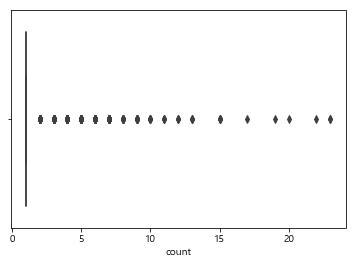

In [36]:
# count == 1이 아니면 전부 이상치로 판단하는 모습
sns.boxplot(x = "count",
            data = df)
plt.show()

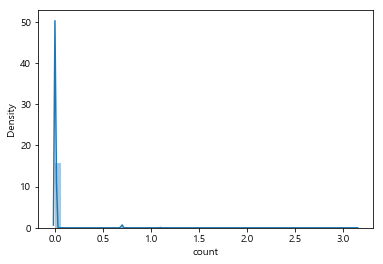

In [37]:
# count 빈도 log
sns.distplot(np.log(df['count']));

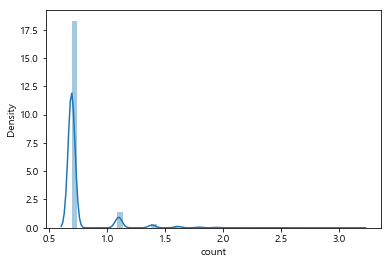

In [38]:
# count != 1 빈도
withoutcount1 = df.drop(df[df['count'] == 1].index)
sns.distplot(np.log(withoutcount1['count']));

<br>

#### 2. corrplot

상관 분석을 위해 corrplot을 그려본다.

count == 1의 값이 압도적으로 많으므로, count == 1을 제외한 데이터의 corrplot도 함께 살펴본다.

##### 1) 전체 corrplot

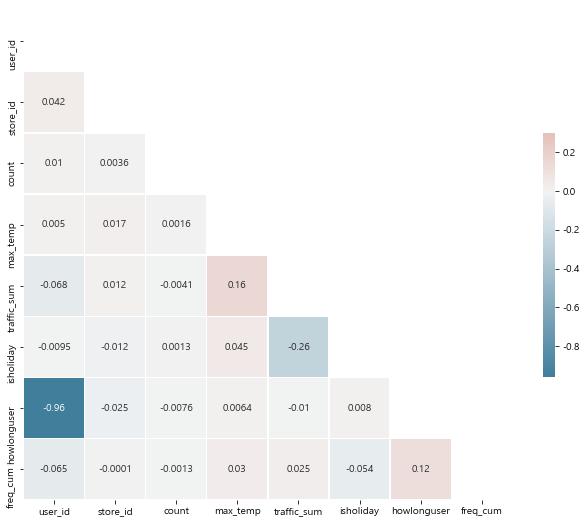

In [39]:
df_corr = df.drop(['year', 'month', 'day', 'weekday', 'week'], 1)

corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

##### 2) count != 1 데이터의 corrplot

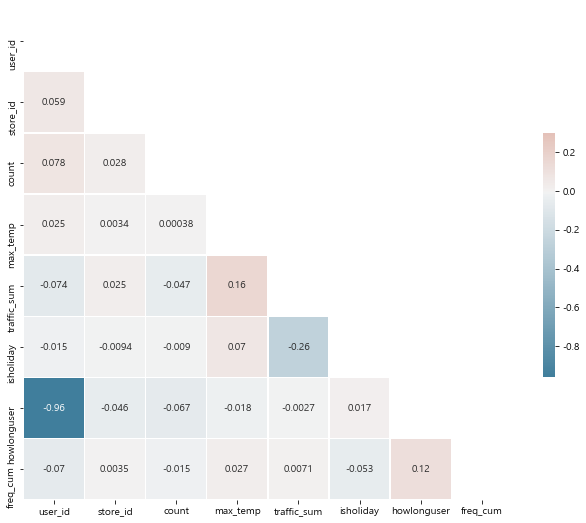

In [40]:
no_one = df_corr[df_corr['count'] != 1]

corr = no_one.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

#### 🤦‍corrplot 결과

0. 데이터가 갖는 편향성(count == 1이 압도적) 때문에 corrplot으로 count와 다른 feature들과의 상관관계를 정확히 파악하기 힘듬
1. count가 1인 경우를 제외하면서 corrplot을 살펴보았을 때도 마찬가지임
2. 2020년 결제 데이터라 `year` 변수는 모델링 관점에서는 의미가 없음
3. `howlonguser`와 `user_id`의 상관계수가 -1에 가깝기 때문에 모델링 시 하나의 변수는 제거 가능

🙆‍♀️ **결론 : 모델링 점수 개선보다 비즈니스적 의사결정을 이끌어낼 수 있는 EDA에 집중해야겠다.**

<br>

#### 3. Features

질문을 던지거나 가설을 세워 데이터를 파악해보자

##### Q1) 요일별 결제량은 어떻게 변할까?

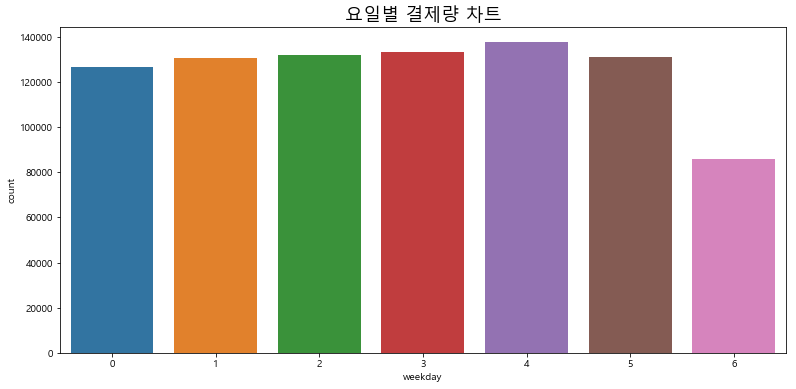

In [41]:
plt.figure(figsize=(13,6))
sns.countplot(data = df, x = 'weekday')
plt.title('요일별 결제량 차트', fontsize=18);

- 금요일 결제량이 조금 더 높다는 점 외에 월요일부터 토요일까지는 큰 변화가 없지만, 일요일 결제량은 크게 감소하는 것을 확인할 수 있다.
<br><br>

##### Q2) 월별 결제량 차트는 어떻게 나타날까?

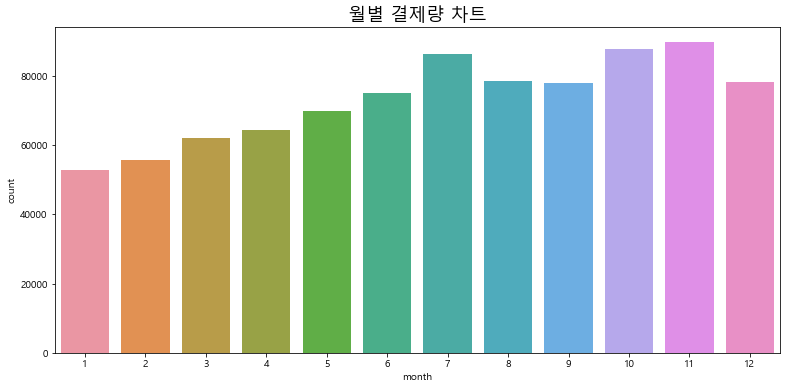

In [42]:
plt.figure(figsize=(13,6))
sns.countplot(data = df, x = 'month')
plt.title('월별 결제량 차트', fontsize=18);

- 1월부터 7월까지 점차 상승하는 모습을 보이다가 잠시 주춤, 이후 10월 11월에 많은 이용량을 보였다.
- 하지만 2020년 결제건만 존재하기 때문에 월별 결제량 차트에서 유의미한 해석은 이끌어내기 힘들다.
<br><br>

##### Q3) 수요가 가장 많은 지역은 어디일까?

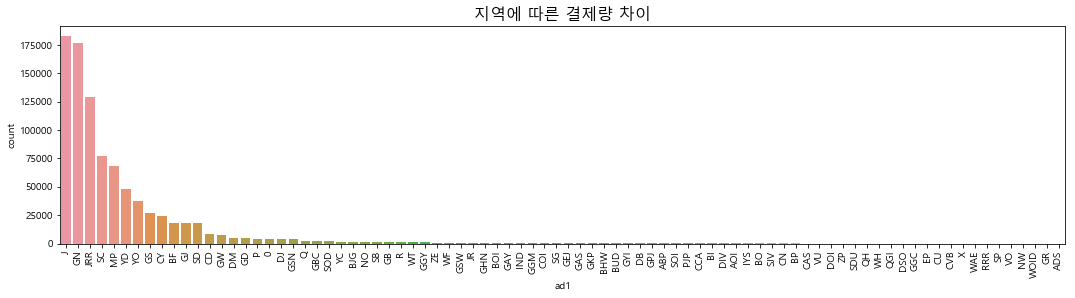

In [43]:
plt.figure(figsize = (18,4))
sns.barplot(data = df.groupby('ad1')['count'].sum().reset_index().sort_values(by = 'count', ascending = False),
            x = 'ad1', 
            y = 'count')
plt.xticks(rotation = 90)
plt.title('지역에 따른 결제량 차이', fontsize = 16)
plt.show()

- 수요가 가장 집중된 지역은 J, GN, JRR, SC, MP 순으로 나타난다.
- 상위 2개 지역, J, GN에 전체 결제의 약 **40%**가 집중된다. 반면 결제 건수가 100회 미만인 지역은 31개로 지역에 따른 편차가 크다는 것을 알 수 있다.

<br>

##### Q4) 최고 기온에 따른 이용량은 어떻게 나타날까?

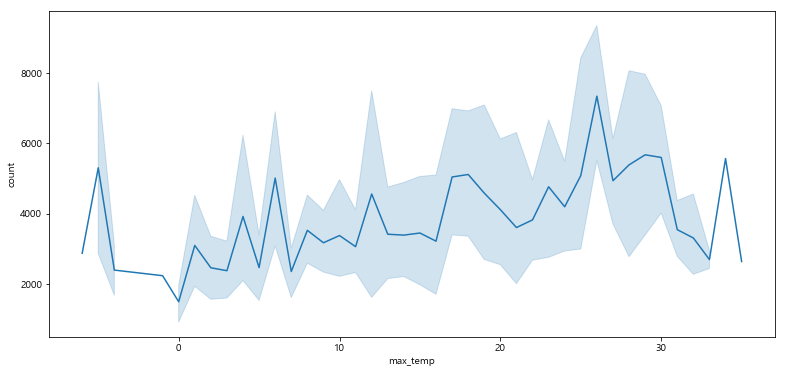

In [44]:
# 평균 온도에 따른 이용량 추이
plt.figure(figsize=(13,6))
df_m_temp = df.groupby('max_temp')['count'].sum().reset_index()
df_m_temp['max_temp'] = round(df_m_temp['max_temp'])
sns.lineplot(data = df_m_temp, x = 'max_temp', y = 'count');

- 최고 기온에 따른 이용량을 보면, `25 ~ 27℃` 사이에 결제량이 많은 걸 확인할 수 있다.<br>
    (그래프는 최고 기온의 소수점 첫째자리에서 반올림)

- 한편 데이터가 2020년에 제한된 데이터이기 때문에, 날짜와 관련된 차트에서 유의미한 해석을 하기는 어렵다.

##### Q5) 잠수 유저는 어떻게 깨울까?

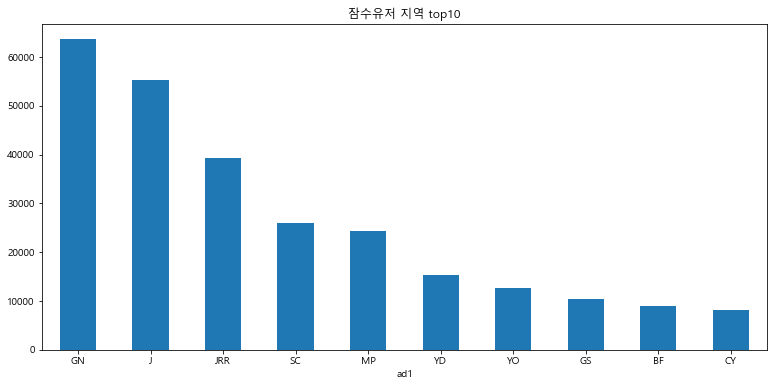

In [45]:
plt.figure(figsize=(13,6))
df.query('active=="잠수유저"').groupby('ad1')['count'].sum().sort_values(ascending=False).head(10).plot(kind='bar', rot=0, title='잠수유저 지역 top10');

- 기업 입장에서는 10명의 불특정 신규 고객보다 기업의 서비스를 애용하다가 멀어져버린 1명의 충성 고객이 더 그리울 것이다.
- 잠수 유저의 수요가 몰린 지역 상위 10곳을 보면 전체 유저의 지역 결제량과 크게 다르지 않고, 역시 상위 3개 지역 GN, J, JRR에 크게 집중됐다는 점을 확인할 수 있었다.

<br>

##### Q6) 불쾌지수에 가장 민감한 반응을 보인 유저는 어떤 유저일까?

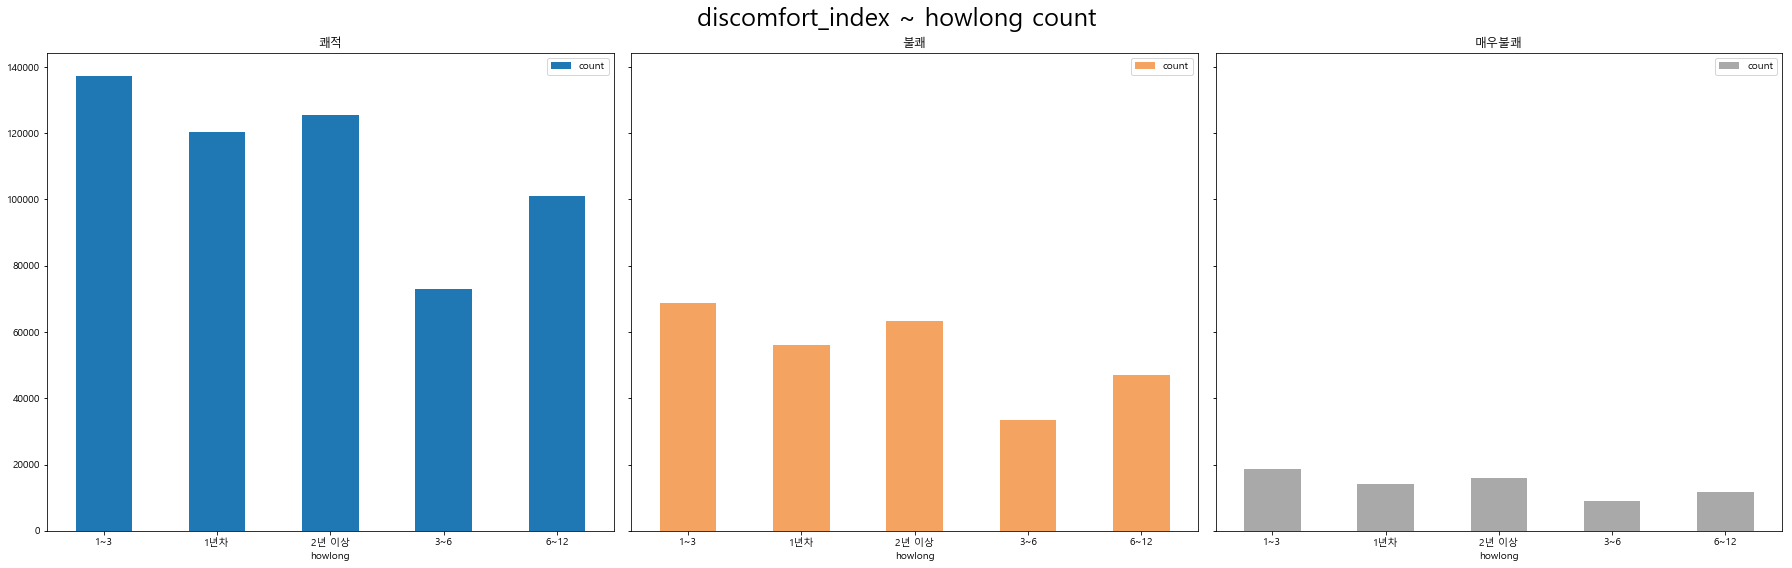

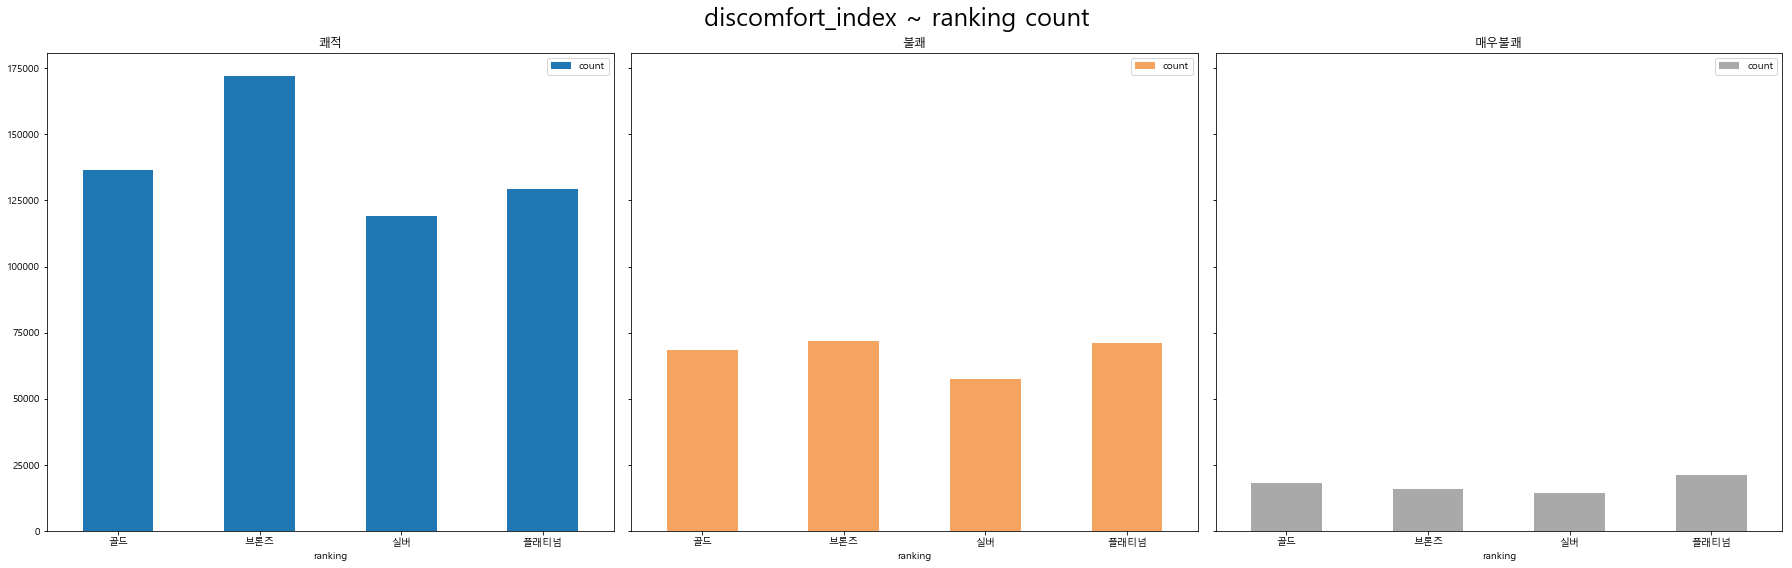

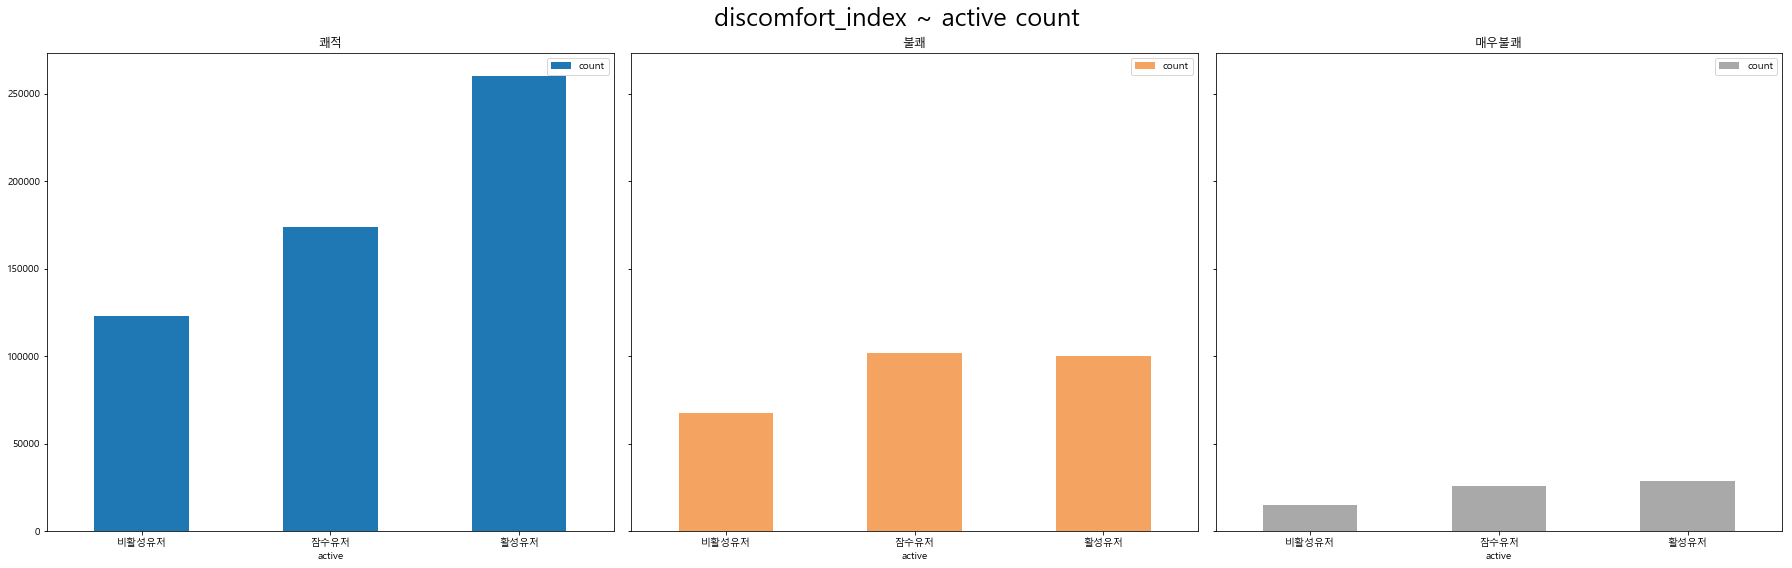

In [46]:
# howlong
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,8), sharey=True, sharex=True)
fig.suptitle('discomfort_index ~ howlong count', fontsize=25)
df.query('discomfort_index=="쾌적"').pivot_table(index='howlong', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0], title='쾌적')
df.query('discomfort_index=="불쾌"').pivot_table(index='howlong', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1], title='불쾌', color = 'sandybrown')
df.query('discomfort_index=="매우불쾌"').pivot_table(index='howlong', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2], title='매우불쾌', color = 'darkgrey')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

print('\n\n')
# ranking
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,8), sharey=True, sharex=True)
fig.suptitle('discomfort_index ~ ranking count', fontsize=25)
df.query('discomfort_index=="쾌적"').pivot_table(index='ranking', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0], title='쾌적')
df.query('discomfort_index=="불쾌"').pivot_table(index='ranking', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1], title='불쾌', color = 'sandybrown')
df.query('discomfort_index=="매우불쾌"').pivot_table(index='ranking', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2], title='매우불쾌', color = 'darkgrey')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

print('\n\n')
# active
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,8), sharey=True, sharex=True)
fig.suptitle('discomfort_index ~ active count', fontsize=25)
df.query('discomfort_index=="쾌적"').pivot_table(index='active', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0], title='쾌적')
df.query('discomfort_index=="불쾌"').pivot_table(index='active', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1], title='불쾌', color = 'sandybrown')
df.query('discomfort_index=="매우불쾌"').pivot_table(index='active', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2], title='매우불쾌', color = 'darkgrey')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

- countplot과 비율을 살펴보았을 때, 불쾌지수에 민감하게 반응하는 유저의 특징을 찾기 힘들다.

<br><br>

##### Q7) extreme_weather에 구애받지 않는 유저는?

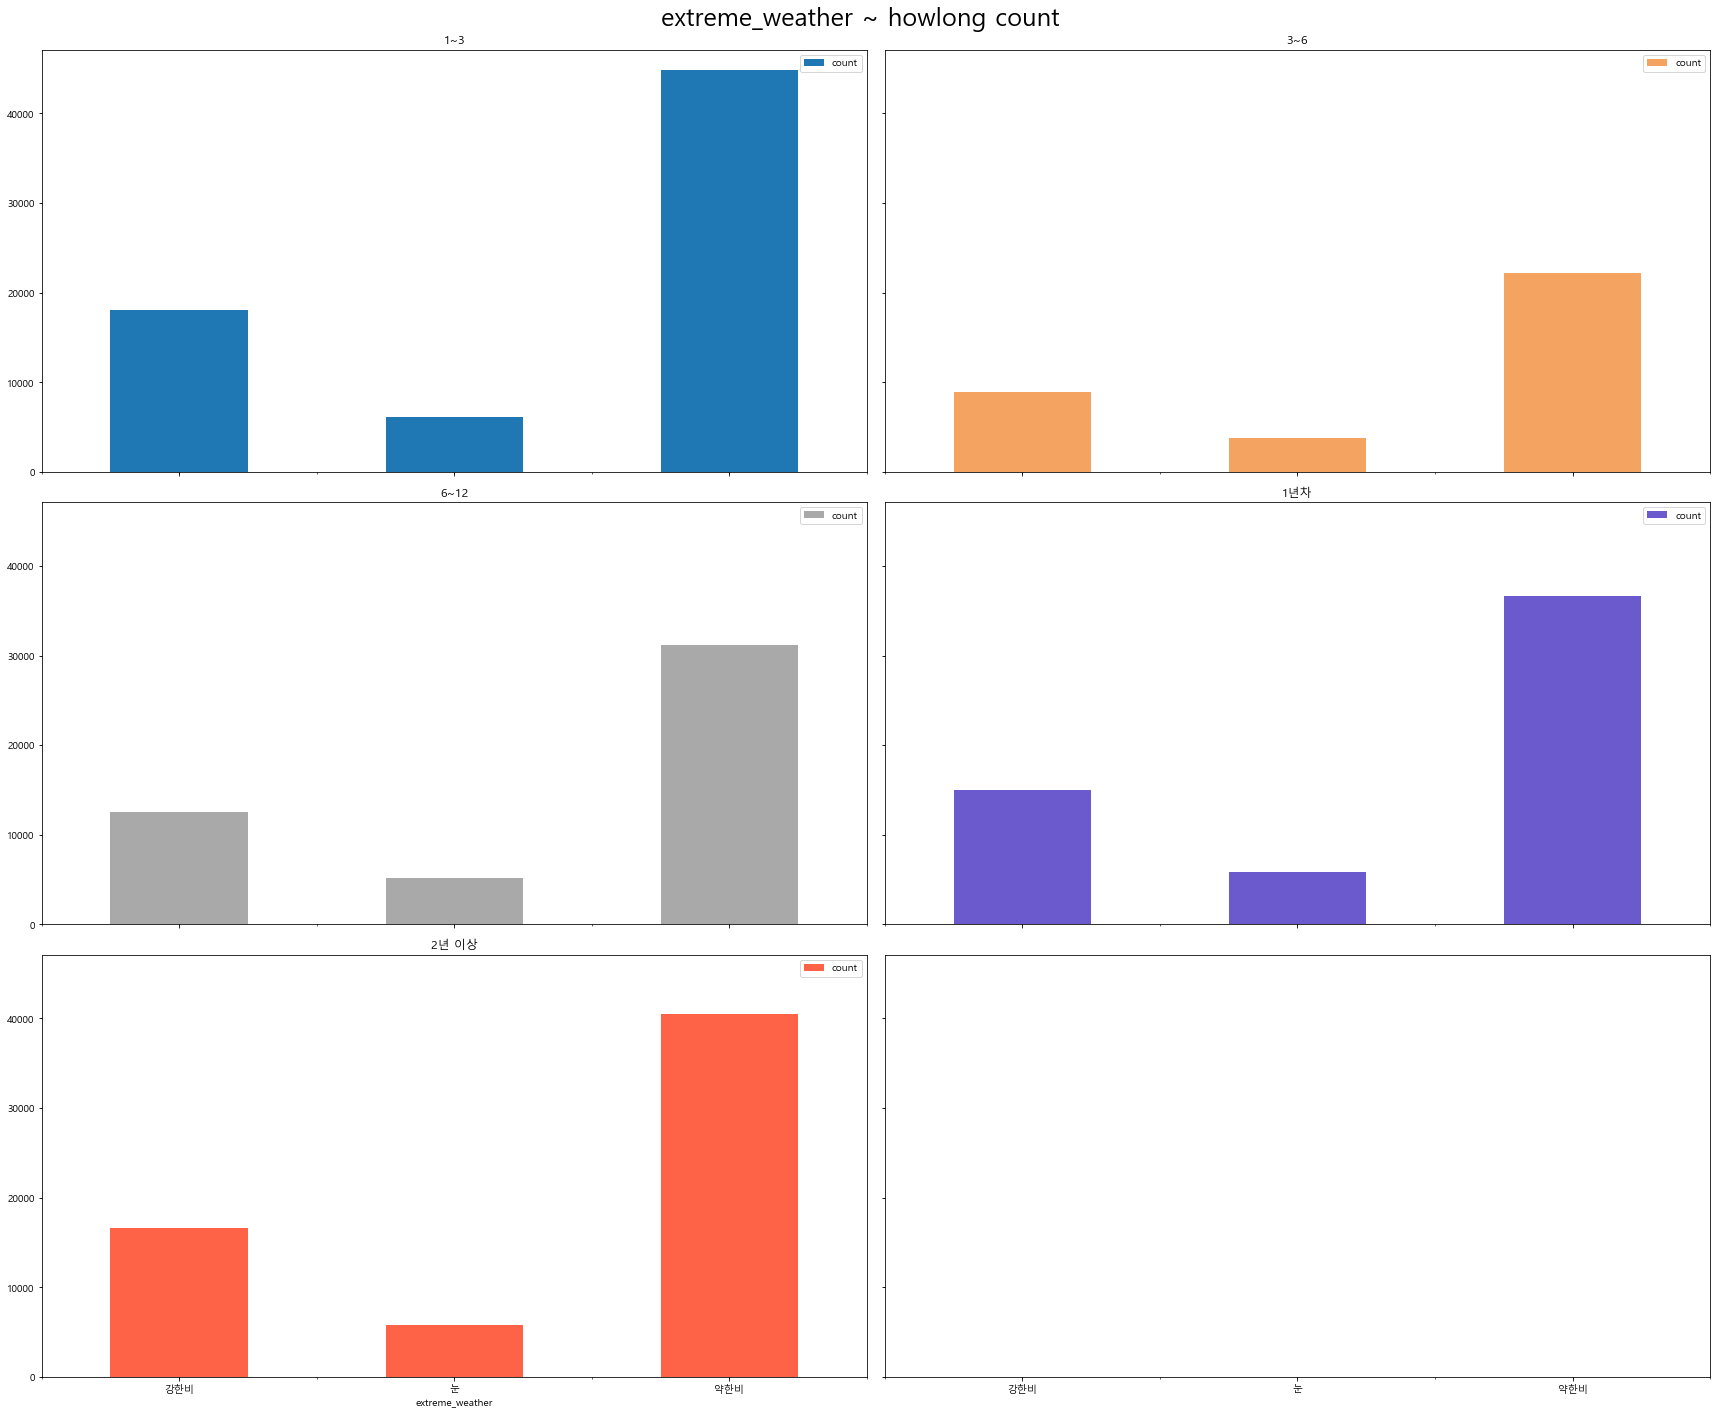

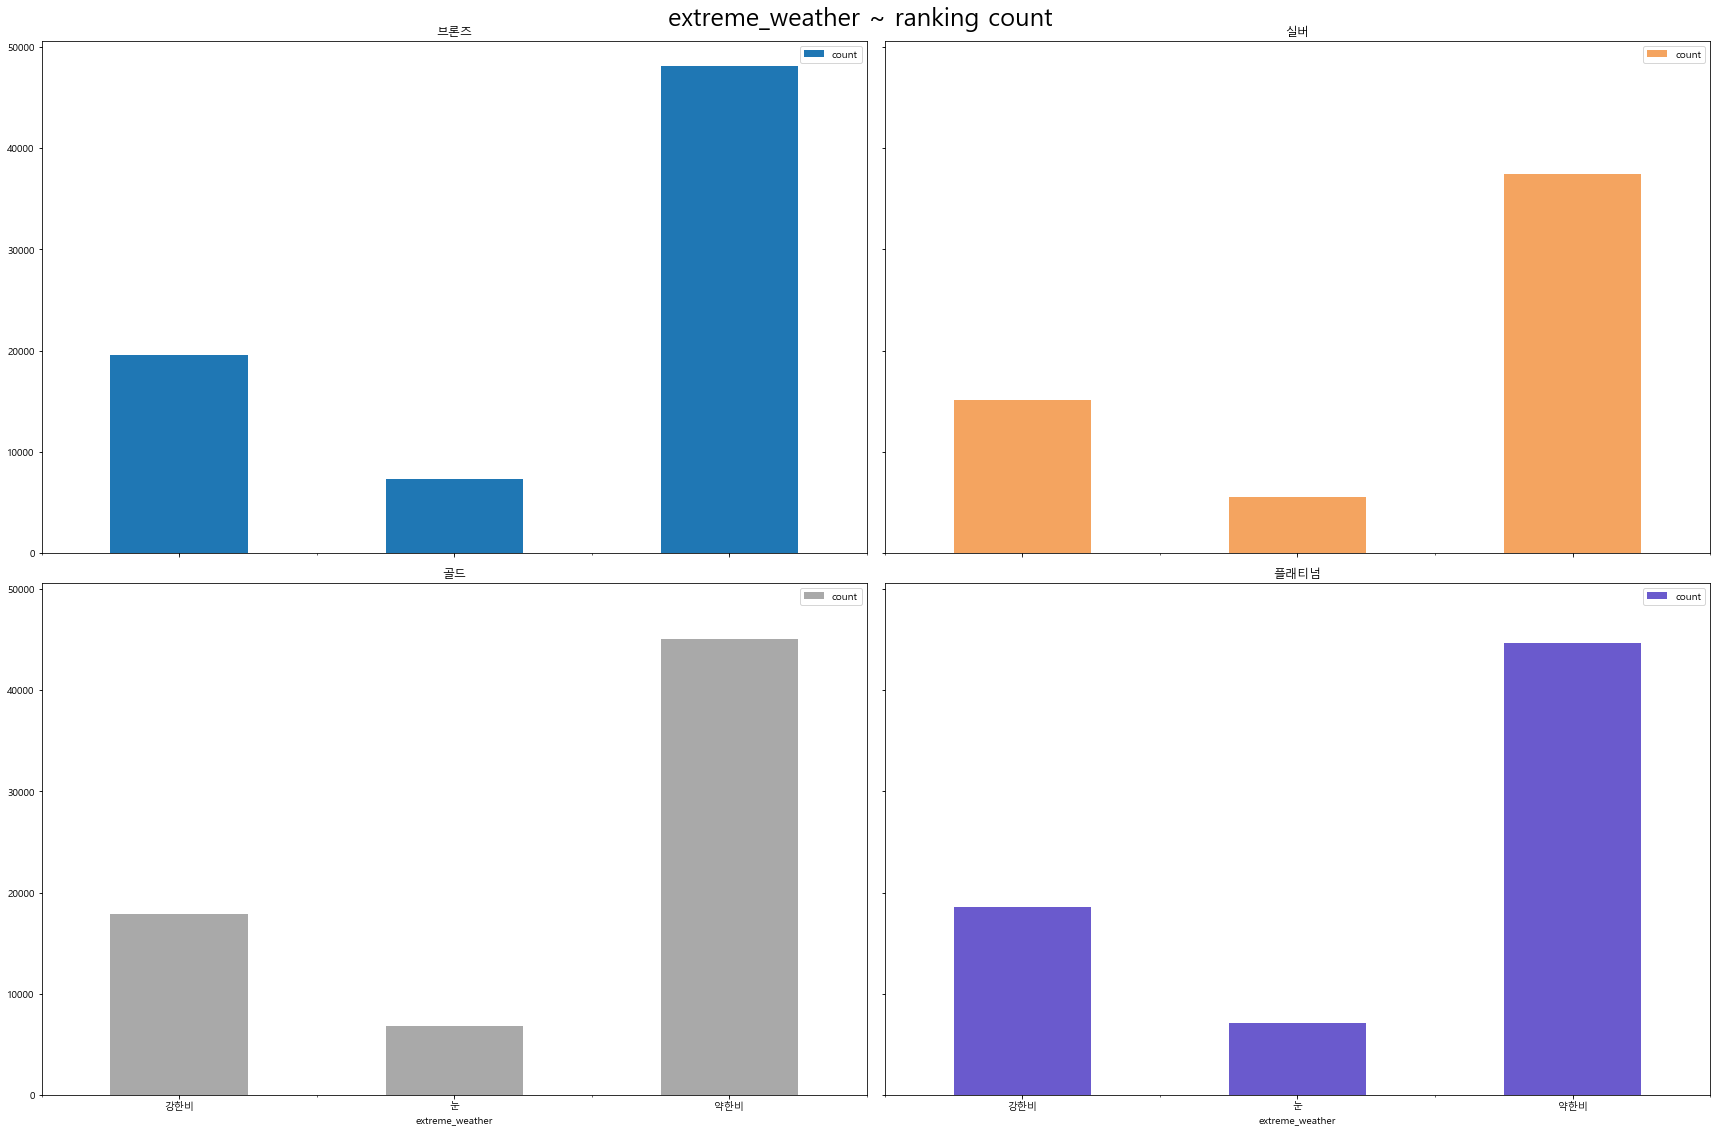

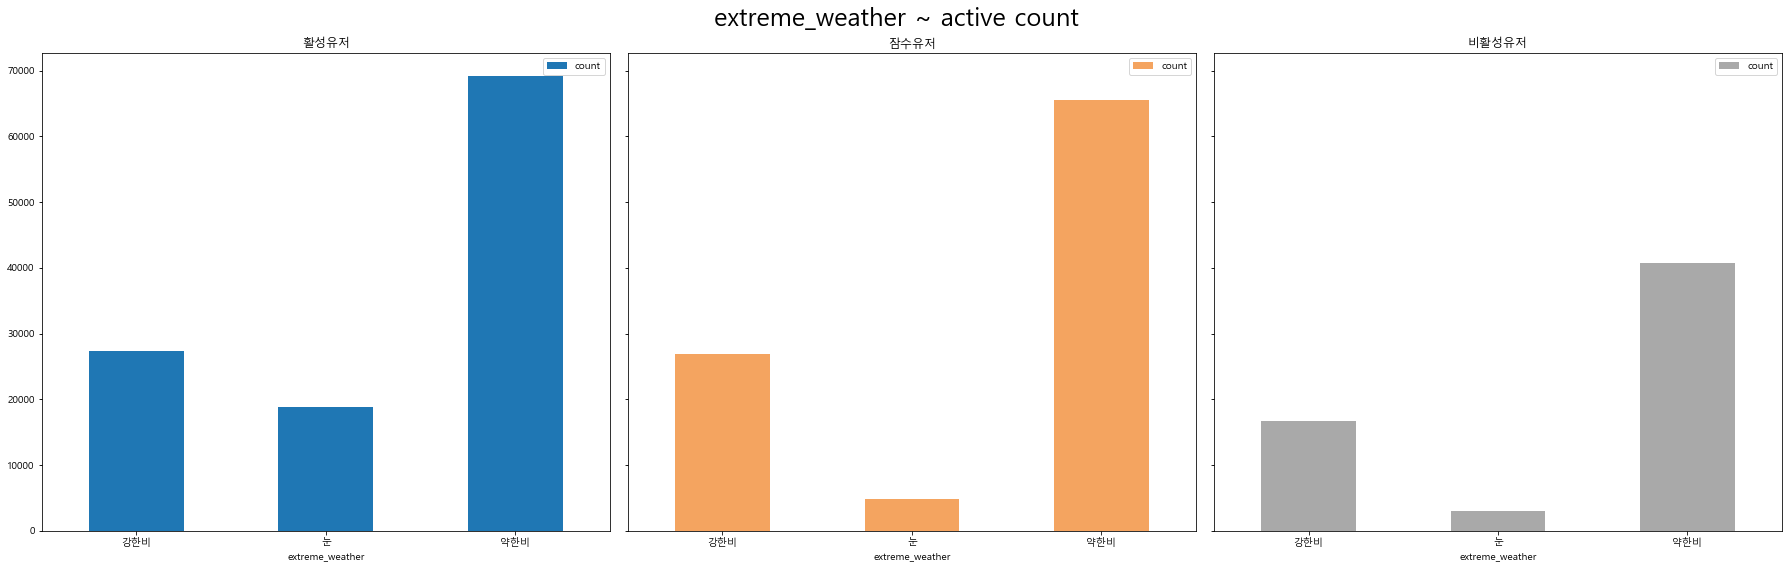

In [47]:
df2 = df[df['extreme_weather'] != "없음"]

# howlong
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(24,20), sharey=True, sharex=True)
fig.suptitle('extreme_weather ~ howlong count', fontsize=25)
df2.query('howlong=="1~3"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='1~3')
df2.query('howlong=="3~6"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='3~6', color = 'sandybrown')
df2.query('howlong=="6~12"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='6~12', color = 'darkgrey')
df2.query('howlong=="1년차"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='1년차', color = 'slateblue')
df2.query('howlong=="2년 이상"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2,0], title='2년 이상', color = 'tomato')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print('\n\n')
# ranking
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(24,16), sharey=True, sharex=True)
fig.suptitle('extreme_weather ~ ranking count', fontsize=25)
df2.query('ranking=="브론즈"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='브론즈')
df2.query('ranking=="실버"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='실버', color = 'sandybrown')
df2.query('ranking=="골드"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='골드', color = 'darkgrey')
df2.query('ranking=="플래티넘"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='플래티넘', color = 'slateblue')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print('\n\n')
# active
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,8), sharey=True, sharex=True)
fig.suptitle('extreme_weather ~ active count', fontsize=25)
df2.query('active=="활성유저"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0], title='활성유저')
df2.query('active=="잠수유저"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1], title='잠수유저', color = 'sandybrown')
df2.query('active=="비활성유저"').pivot_table(index='extreme_weather', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2], title='비활성유저', color = 'darkgrey')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

- `howlong`과 `ranking`에 대해서는 `extreme_weather`에 따른 차이가 나타나지 않는다.
- **활성유저**는 눈이 오늘 날 주차장을 찾기 위한 활동에 조금 더 적극적이다.

In [48]:
snow = df[df['extreme_weather'] == '눈'][['user_id', 'join_date', 'date']].drop_duplicates()
print(len(snow))
snow['gap'] = (snow['date'] - snow['join_date']).dt.days
len(snow[snow['gap'] == 0])


26211


901

- 한편 2020년 눈이 내리는 날 당일에 모두의 주차장 앱에 가입하여 결제까지 진행한 유저는 901명으로, 전체 눈 오는 날 결제 건수의 `3.4%` 정도이다.

<br><br>

##### Q8) 유저의 가입기간, 등급, 활성화 정도에 따라 요일별 이용이 어떻게 달라질까?

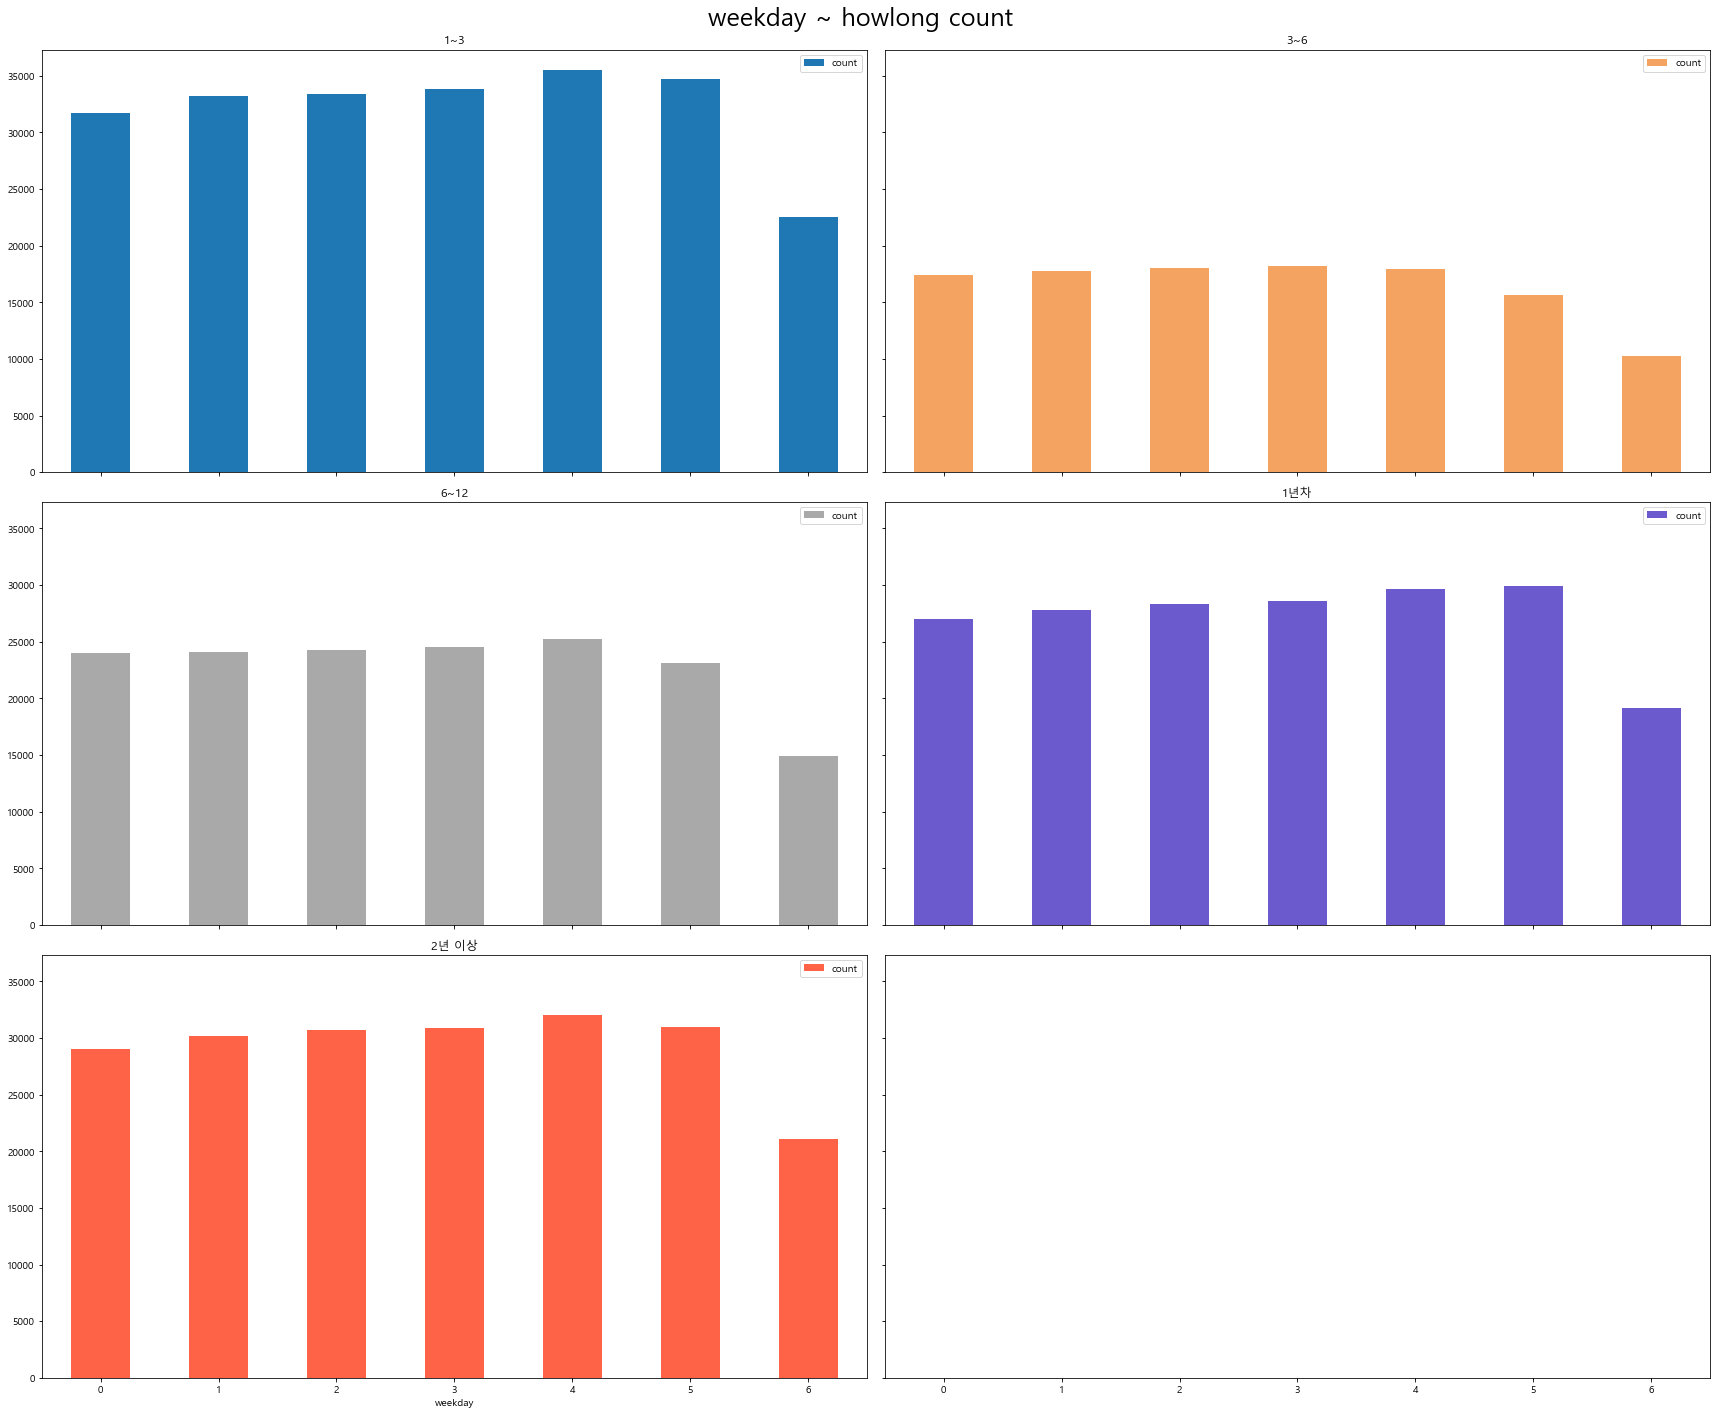

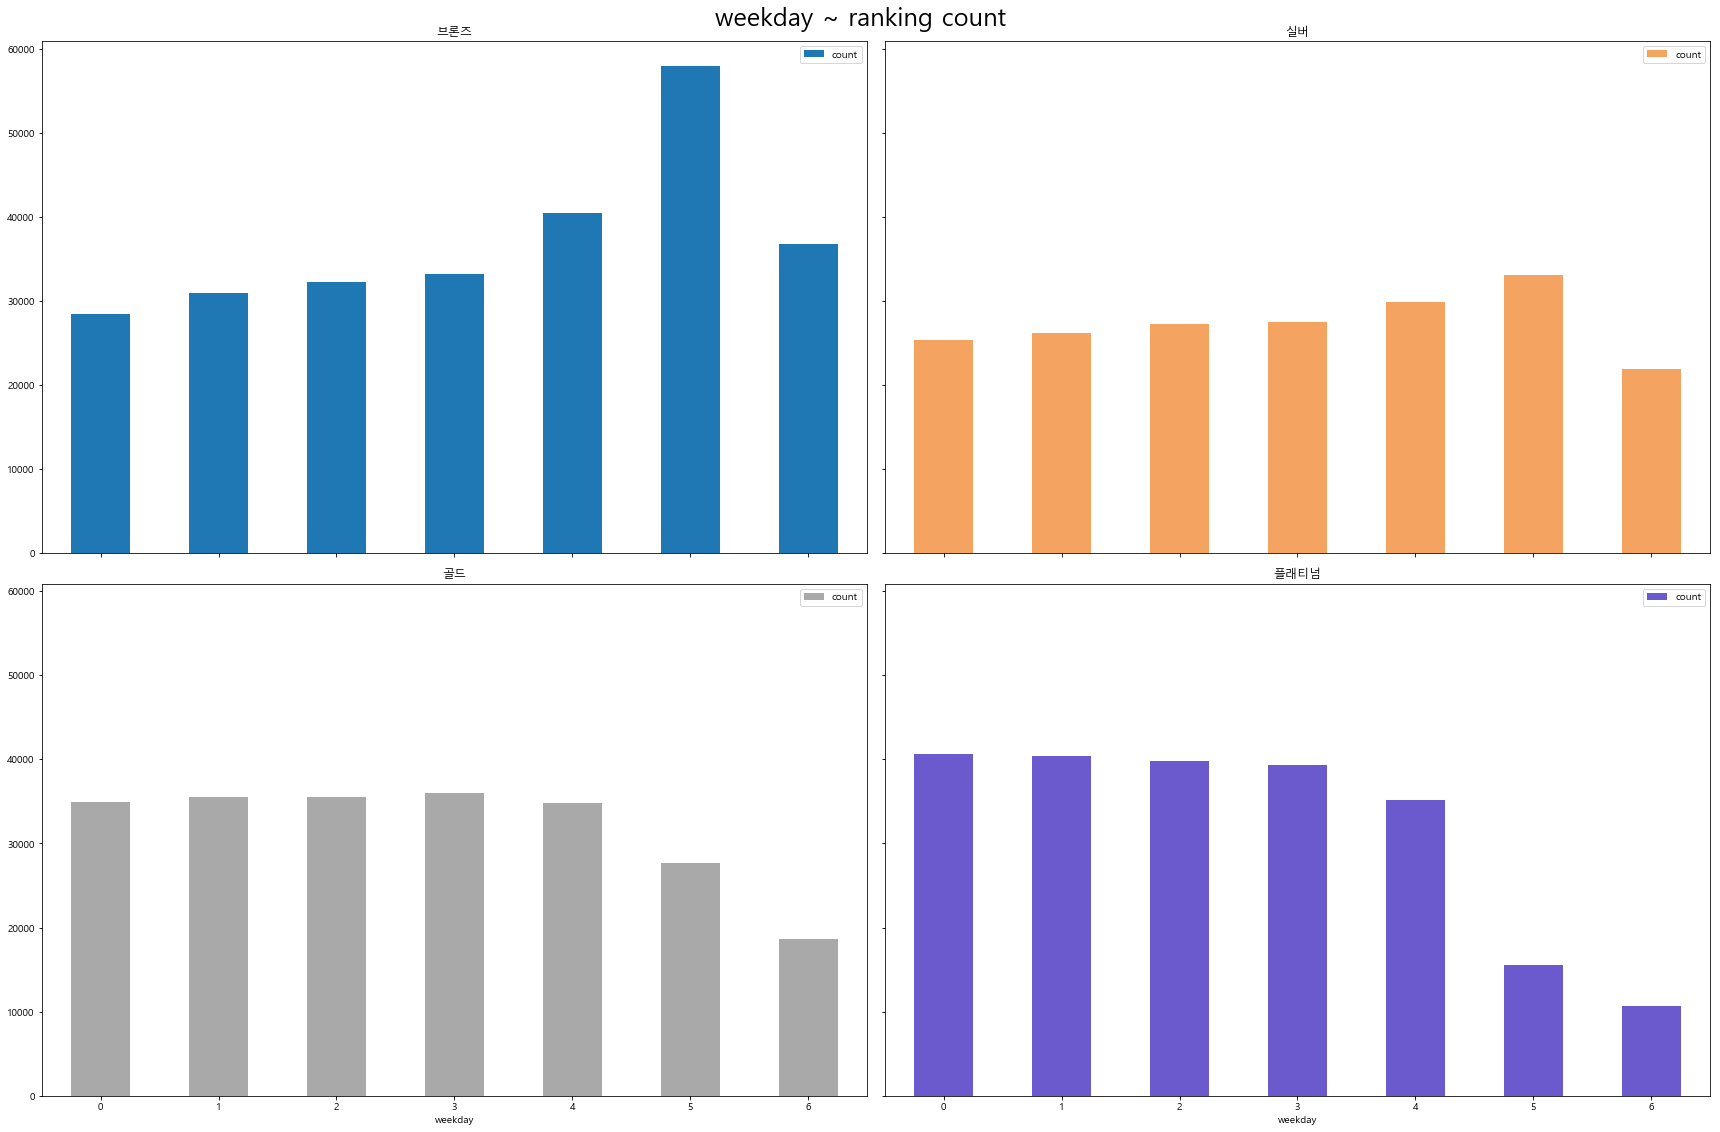

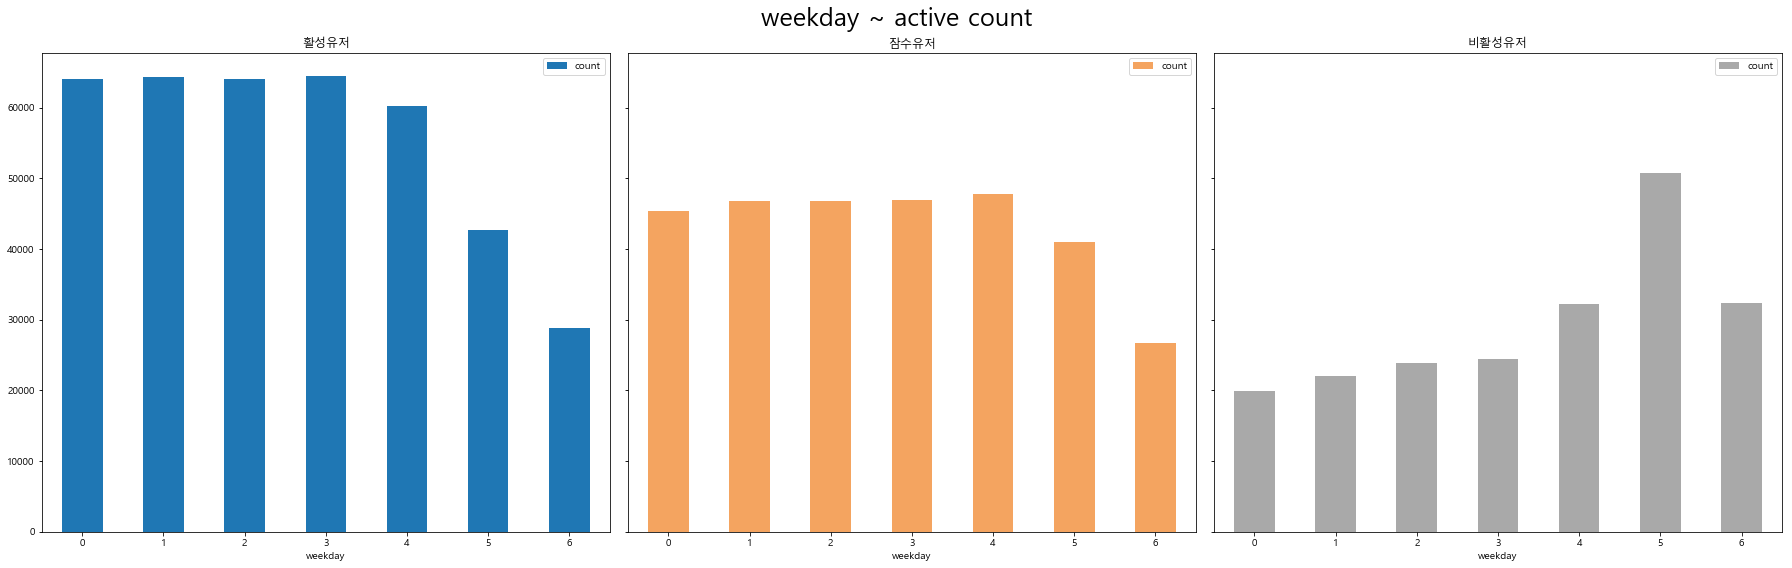

In [49]:
# howlong
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(24,20), sharey=True, sharex=True)
fig.suptitle('weekday ~ howlong count', fontsize=25)
df.query('howlong=="1~3"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='1~3')
df.query('howlong=="3~6"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='3~6', color = 'sandybrown')
df.query('howlong=="6~12"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='6~12', color = 'darkgrey')
df.query('howlong=="1년차"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='1년차', color = 'slateblue')
df.query('howlong=="2년 이상"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2,0], title='2년 이상', color = 'tomato')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print('\n\n')
# ranking
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(24,16), sharey=True, sharex=True)
fig.suptitle('weekday ~ ranking count', fontsize=25)
df.query('ranking=="브론즈"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='브론즈')
df.query('ranking=="실버"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='실버', color = 'sandybrown')
df.query('ranking=="골드"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='골드', color = 'darkgrey')
df.query('ranking=="플래티넘"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='플래티넘', color = 'slateblue')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print('\n\n')
# active
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,8), sharey=True, sharex=True)
fig.suptitle('weekday ~ active count', fontsize=25)
df.query('active=="활성유저"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0], title='활성유저')
df.query('active=="잠수유저"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1], title='잠수유저', color = 'sandybrown')
df.query('active=="비활성유저"').pivot_table(index='weekday', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2], title='비활성유저', color = 'darkgrey')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

- 유저의 가입기간에 따른 요일별 이용량은 큰 차이가 없다.
- 등급이 높은 유저일수록(모두의 주차장 앱을 많이 이용한 유저일수록) 주중 이용 횟수가 주말 이용 횟수보다 많아진다. 
- 활성유저는 평일 이용량이 주말보다 높다. 
- 잠수유저의 이용량 추이는 활성유저와 비슷하지만, **비활성 유저의 경우는 정반대로 이용량이 금토일에 집중적으로 나타났다.**

<br><br>

##### Q9) 유저의 가입기간, 등급, 활성화 정도에 따라 goods_type 이용이 어떻게 달라질까?

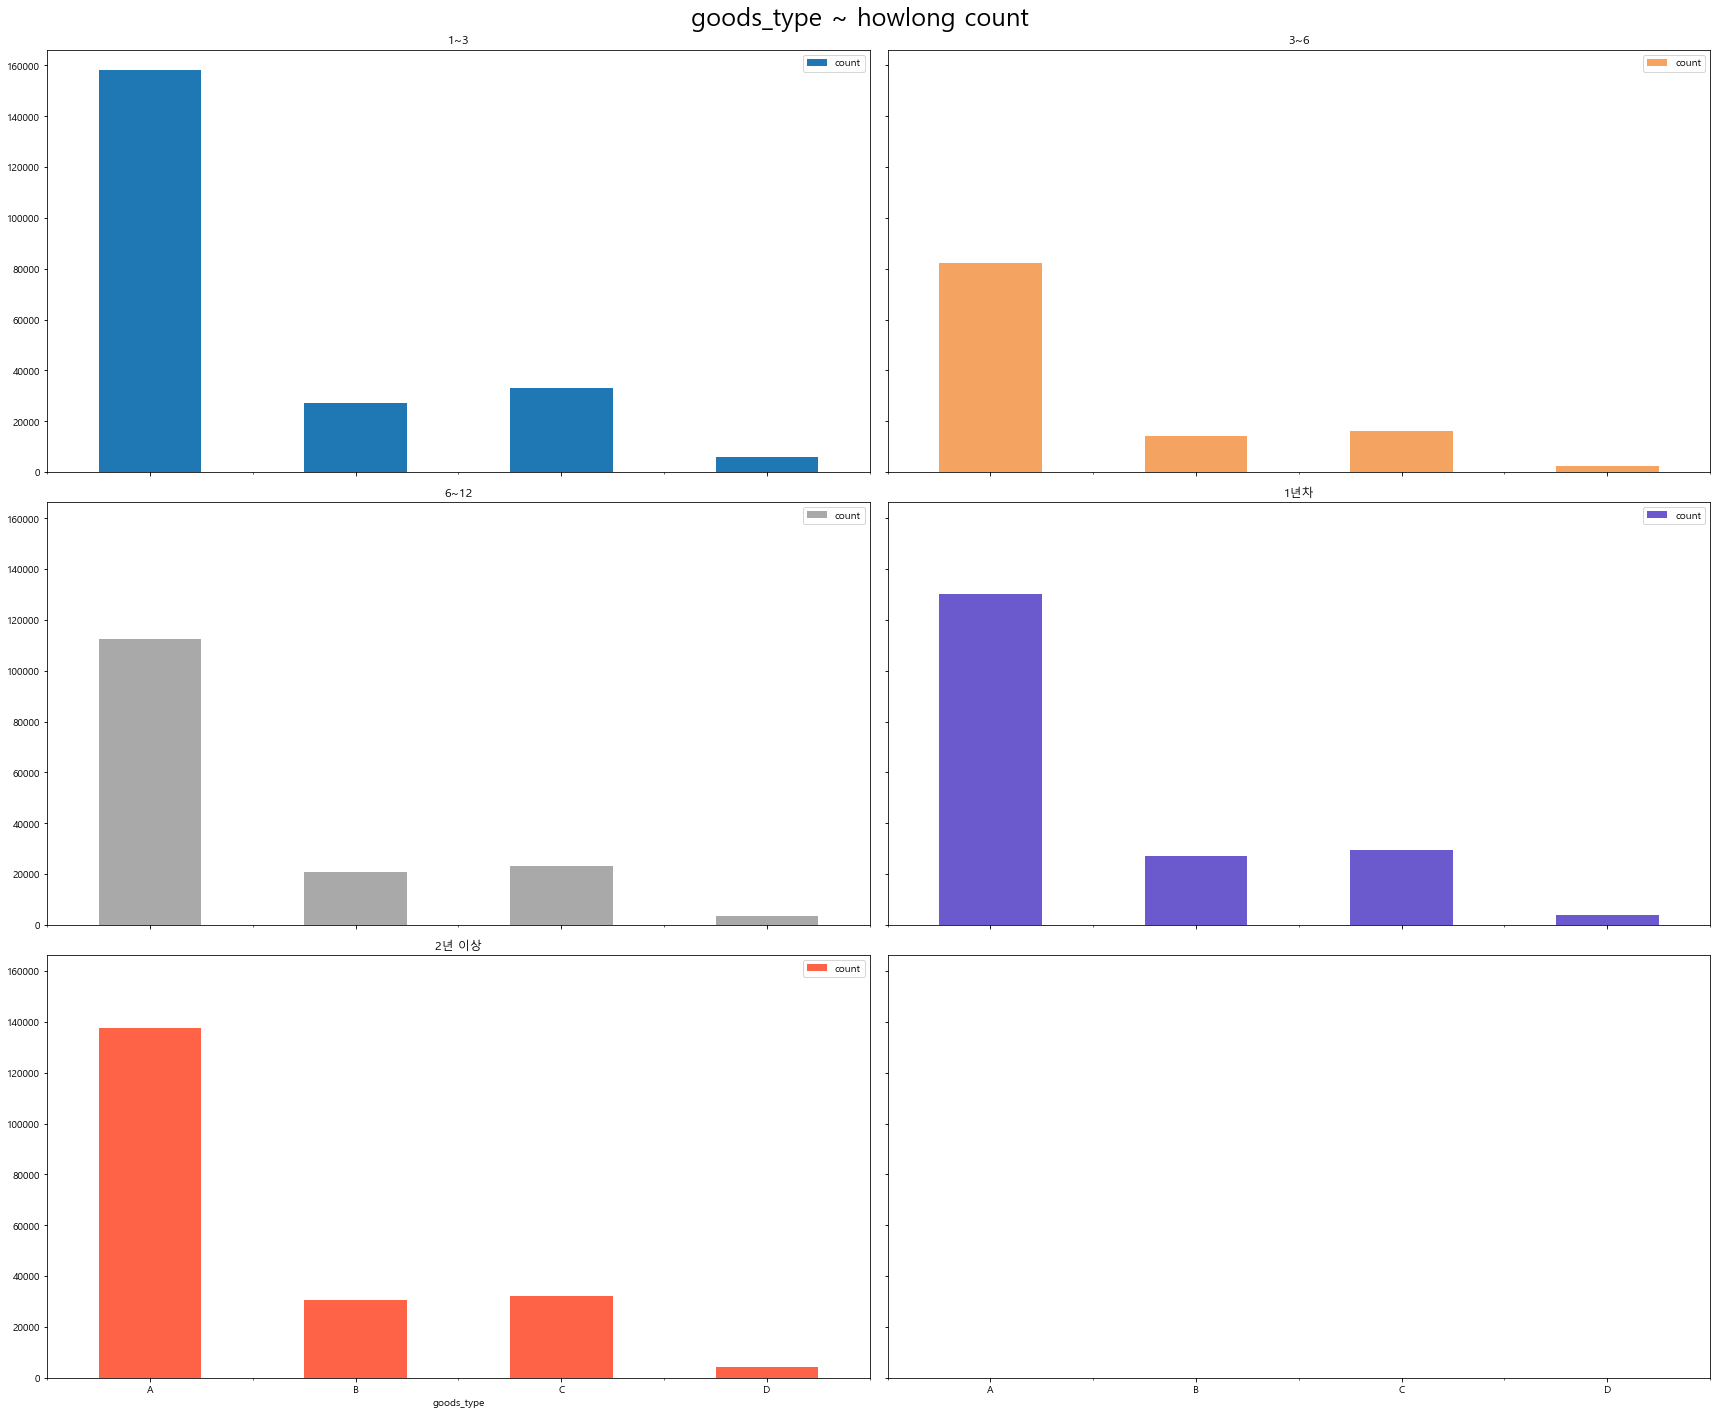

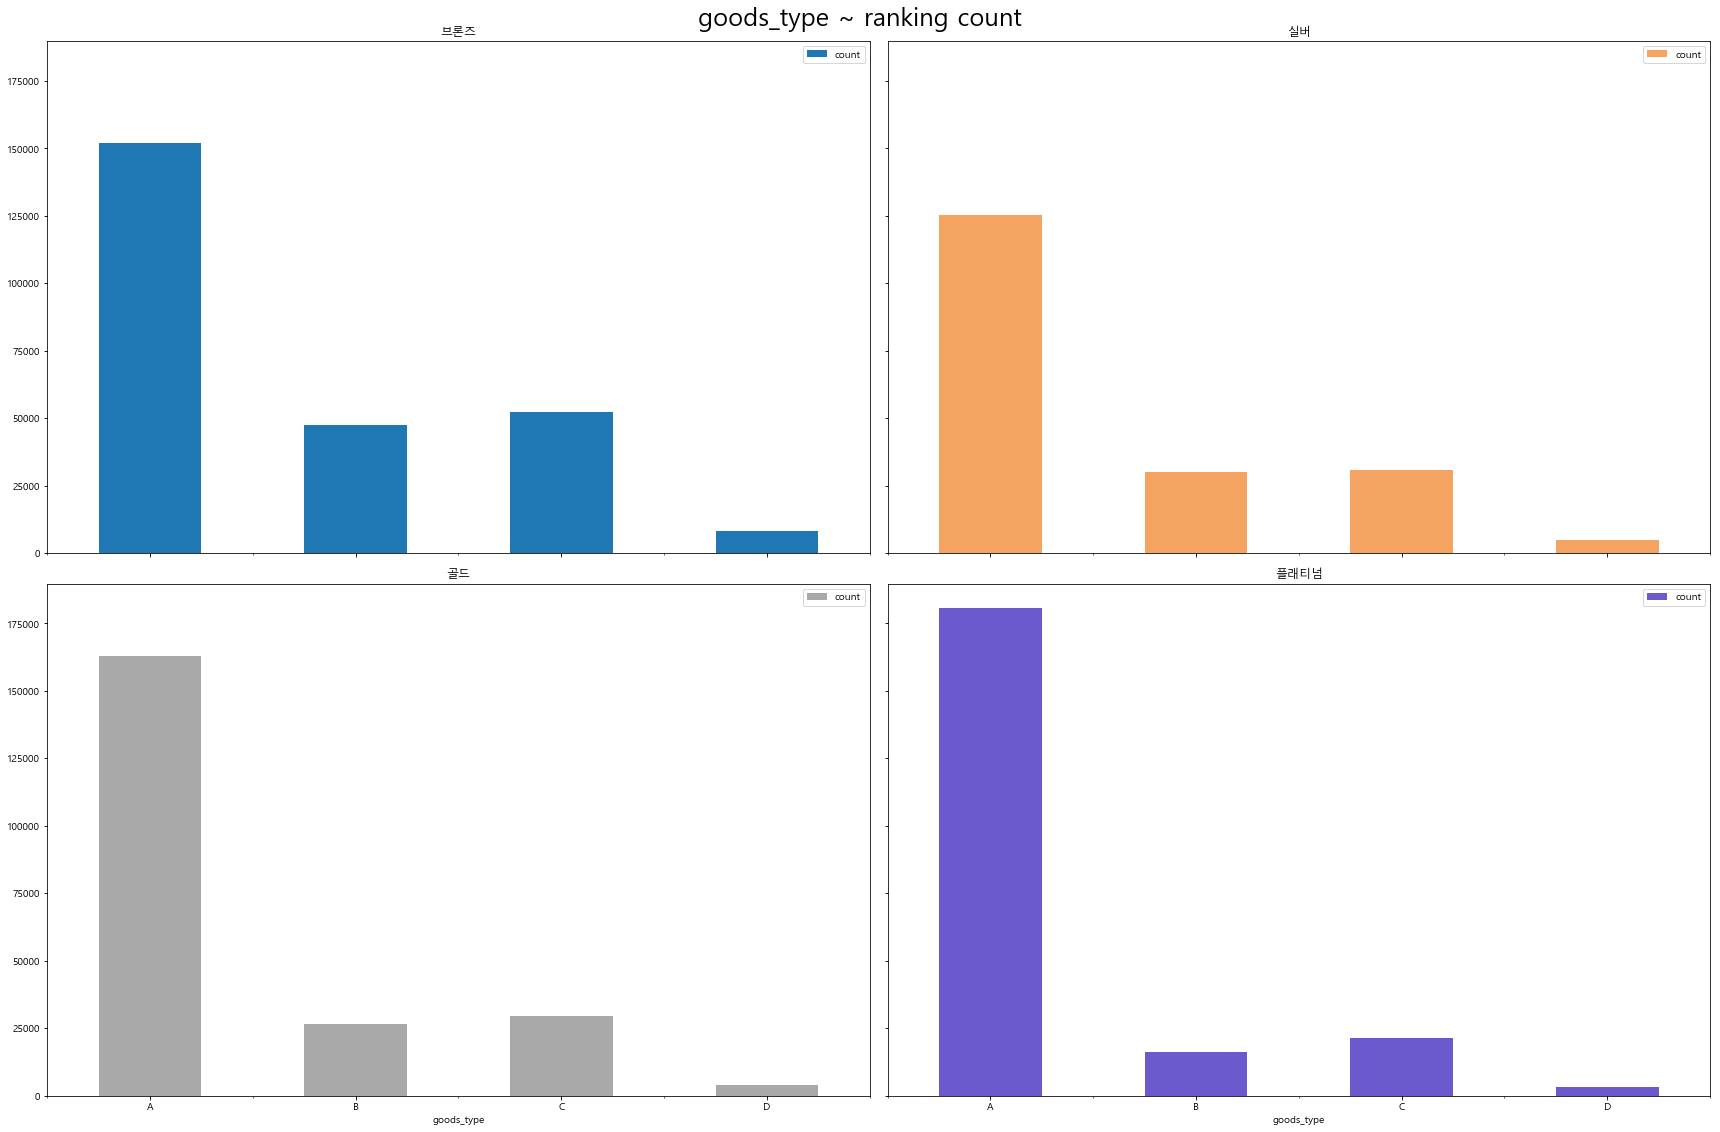

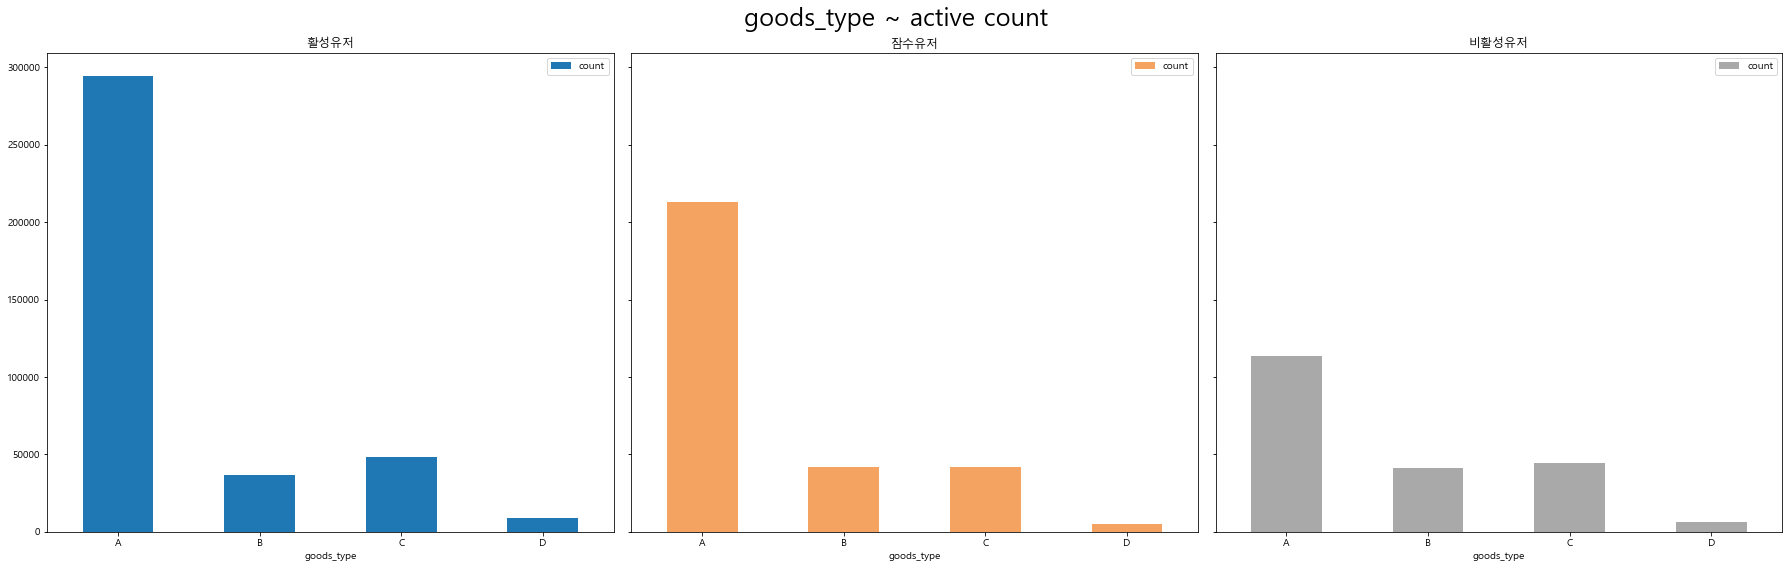

In [50]:
# howlong
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(24,20), sharey=True, sharex=True)
fig.suptitle('goods_type ~ howlong count', fontsize=25)
df.query('howlong=="1~3"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='1~3')
df.query('howlong=="3~6"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='3~6', color = 'sandybrown')
df.query('howlong=="6~12"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='6~12', color = 'darkgrey')
df.query('howlong=="1년차"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='1년차', color = 'slateblue')
df.query('howlong=="2년 이상"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2,0], title='2년 이상', color = 'tomato')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print('\n\n')
# ranking
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(24,16), sharey=True, sharex=True)
fig.suptitle('goods_type ~ ranking count', fontsize=25)
df.query('ranking=="브론즈"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,0], title='브론즈')
df.query('ranking=="실버"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0,1], title='실버', color = 'sandybrown')
df.query('ranking=="골드"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,0], title='골드', color = 'darkgrey')
df.query('ranking=="플래티넘"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1,1], title='플래티넘', color = 'slateblue')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

print('\n\n')
# active
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(25,8), sharey=True, sharex=True)
fig.suptitle('goods_type ~ active count', fontsize=25)
df.query('active=="활성유저"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[0], title='활성유저')
df.query('active=="잠수유저"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1], title='잠수유저', color = 'sandybrown')
df.query('active=="비활성유저"').pivot_table(index='goods_type', 
               values='count', 
               aggfunc='sum').plot(kind='bar', rot=0, ax=axes[2], title='비활성유저', color = 'darkgrey')
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

- 가입 기간에 따른 `goods_type` 이용의 차이는 보이지 않는다.
- 등급에 따라 `goods_type` 이용을 살펴보았을 때, **모두의 주차장 앱을 많이 이용한 유저(골드, 플레티넘)일수록 상대적으로 type A를 많이 이용하는 것으로 보인다.** 
- 그리고 이용량이 적은 유저(브론즈, 실버)일수록 상대적으로 B와 C type을 더 구매하는 것을 알 수 있다.
- 유저 활성화 정도의 경우 전반적으로 Type A를 가장 많이 이용하며, 다른 type을 특히 더 많이 쓰는 구분은 보이지 않는다.

##### Q10) 어떤 고객에 초점을 맞춰야 할까? (Cohort 분석)

1) Retention

In [51]:
df_retention = df.sort_values(['user_id','date']).reset_index(drop=True).copy()

# 2020년 첫 구매일자
df_retention_first= pd.DataFrame(df_retention.groupby('user_id')['date'].min()).reset_index()
df_retention_first.columns=['user_id','first']

# 첫구매일자정보 추가
df_retention = df_retention.merge(df_retention_first, on='user_id', how='left')

df_retention['isrepeated'] = np.where(df_retention['date'] != df_retention['first'],1,0)

df_retention['first']= pd.to_datetime(df_retention['first'])

In [52]:
# cohort_month : 첫 구매 월
df_retention['cohort_month'] = df_retention['first'].dt.month

# count_month : 구매 월
df_retention['date']= pd.to_datetime(df_retention['date'])
df_retention['count_month']=df_retention['date'].dt.month

# roll up data by cohort group(첫구매월) & count_month(구매월) 
# 결제 횟수 count > sum
df_retention_cohorts = df_retention.groupby(['cohort_month', 'count_month']).agg({'user_id': pd.Series.nunique,'count': np.sum})
df_retention_cohorts = df_retention_cohorts.rename(columns={'user_id': 'total_users', 'count':'total_counts'})

# 첫 구매월 이후 기간 생성 1~12
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

df_retention_cohorts = df_retention_cohorts.groupby(level=0).apply(cohort_period)

df_retention_cohorts.reset_index(inplace=True)
df_retention_cohorts.set_index(['cohort_month', 'cohort_period'], inplace=True)

# cohort group별 user수 (size) > pct 계산을 위해
cohort_group_size = df_retention_cohorts['total_users'].groupby(level=0).first()

df_retention_cohorts_pct = df_retention_cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)

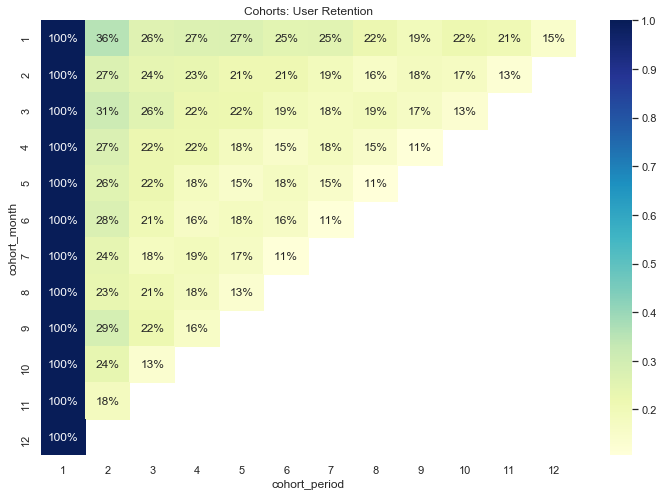

In [53]:
sns.set(style='white')
colormap = plt.cm.PuBu

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(df_retention_cohorts_pct.T, mask=df_retention_cohorts_pct.T.isnull(), annot=True, fmt='.0%', cmap='YlGnBu');

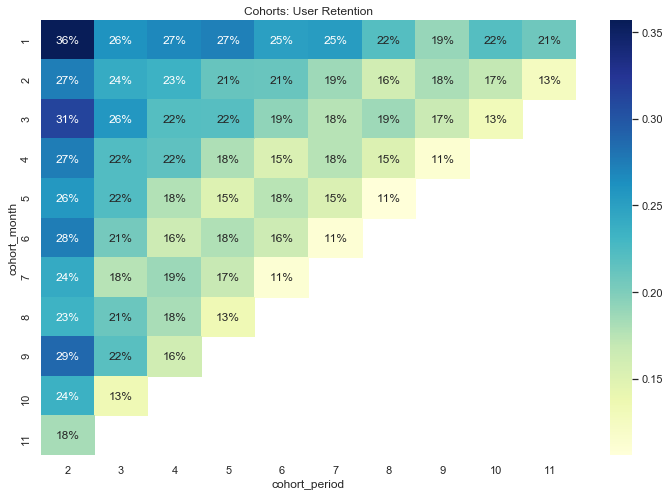

In [54]:
# 시작월 제외
sns.set(style='white')
colormap = plt.cm.PuBu

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(df_retention_cohorts_pct.T.iloc[0:11,1:11], mask=df_retention_cohorts_pct.T.iloc[0:11,1:11].isnull(), annot=True, fmt='.0%', cmap='YlGnBu');

그래프 해석 : <br>
1월 구매 경력이 있는 유저가 2월에도 구매한 비율이 36%다. <br>
→ 1월 구매 경력이 있는 유저가 3월에도 구매한 비율이 26%다. <br> 
→ ...

- retention(사용자 유지율)을 보았을 때, 재구매(2번 째 결제) 이후 retention은 높은 편이라고 말할 수 있다.
- 첫 결제 후 고객이 이탈하는 요인을 찾고, 재구매까지의 이탈률을 줄일 수 있는 퍼널 분석이 필요해 보인다.

<br> 

##### 2) 재결제율

In [55]:
##한번이라도 결재한 사람의 재결제 비율 (2020년 기준)
df_user = df.groupby('user_id')['count'].sum().reset_index()

##한번 이상 결재한 사람의 재결제 비율 
pay_more_than_2 = df_user.query('count > 1')['user_id'].count() / df_user.query('count >= 1')['user_id'].count()
print(pay_more_than_2)

##두번 이상 결재한 사람의 재결제 비율 
pay_more_than_2 = df_user.query('count > 2')['user_id'].count() / df_user.query('count >= 2')['user_id'].count()
print(pay_more_than_2)

##세번 이상 결재한 사람의 재결제 비율 
pay_more_than_2 = df_user.query('count > 3')['user_id'].count() / df_user.query('count >= 3')['user_id'].count()
print(pay_more_than_2)

0.5532090094453863
0.7067572892040977
0.775842044134727


In [56]:
def pay_again_rate(column, count):
    
    pay_rate = df_user.query(f'count > {count}')[f'{column}'].count() / df_user.query(f'count >= {count}')[f'{column}'].count()
    
    return pay_rate

In [57]:
pay_again_list = []

for i in range(1, 50):
    
    pay_again_list.append(pay_again_rate('user_id', i))
    
pay_again_list = pd.DataFrame({'재결제율' : pay_again_list})
pay_again_list = pay_again_list.rename_axis('index').reset_index()

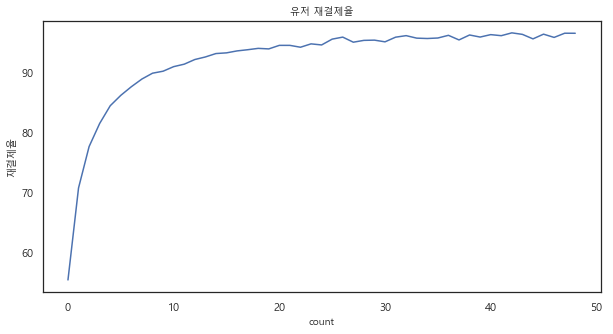

In [58]:
plt.figure(figsize = (10, 5))
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.lineplot(pay_again_list['index'], pay_again_list['재결제율']*100)
plt.title('유저 재결제율', fontsize=10)
plt.ylabel('재결제율', fontsize=10)
plt.xlabel('count', fontsize=10)
plt.show()

해석 : 
<br>한 번 이상 결제한 유저가 재결제할 비율 : 55% 
<br>→ 두 번 이상 결제한 유저가 재결제할 비율 : 70% 
<br>→ 세 번 이상 결제한 유저가 재결제할 비율 : 77% 
<br>→ …

- 유저의 결제 횟수가 높아질수록 이탈률은 낮아진다.
- Retention 시각화와 비슷한 해석으로, 어느 정도 안정된 고객을 확보하기 위해서는 극초반 재결제율을 높이는 방안을 모색해야 한다.

<br>

### 🚙 EDA 내용 정리 및 마케팅 제안

1. `count == 1` 값이 압도적이라 `corrplot`에서 모든 feature가 count와의 상관관계 값으로 0을 갖는다. 로그를 씌워도 정규성 확보가 어렵다.
<br>

2. corrplot의 상관관계는 count가 1인 경우를 제외하고 보더라도 크게 달라지지 않는다. 
    <br>이외에도 다른 방식으로 살펴보았는데 count가 8 이상일 때 count와 다른 변수 간 상관계수에 의미있는 숫자들이 등장했다. 그렇지만 이 경우는 데이터가 70개 정도로 상관 분석을 하기에 적당하지 않다. 따라서 해당 데이터로 상관관계를 분석하는 것은 의미가 없다고 판단한다.
<br>

3. 비활성유저와 잠수유저의 특징에 맞게 **고객을 깨우는 방법이 달라져야 한다.**
    <br>예) 잠수 유저는 강남 지역에 평일 주차권 할인 쿠폰을, 비활성유저는 금토일 주차권 쿠폰 제공 등
<br>

4. 유저 등급에 따라 프로모션을 다르게 해야 한다.
    <br>예) 신규유저(브론즈 등급)에게는 불금 또는 **주말** 나들이 프로모션을, 고인물 유저일수록 **평일** 무료 주차권 프로모션 진행 등
<br><br>

5. **첫 결제와 재구매 사이의 이탈률 요인을 찾는 퍼널 분석이 진행되어야 한다.**<br>
    `Retention`과 `재결제율 그래프`를 확인했을 때, 재결제가 이루어졌다면 이후 고객이 남아서 앱을 이용할 확률이 높아진다. 따라서 신규 유저들의 발을 붙잡아 재결제까지 이끌어낼 수 있는 전략이 필요해보인다. 신규 유저의 금토일 결제량이 많다는 점을 이용해 다음과 같은 프로모션을 생각해볼 수 있다.
    <br>예) 금요일 새벽 - 토요일 주간까지 이어지는 주차권 2장을 구매하면 추가 할인
    <br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;값이 저렴한 주차장이 있는 나들이 장소 추천 푸시 알람 : 대림 미술관 주차권 시간 당 천원에 지금 구매하세요!
    
<br>

## 모델을 통한 예측 - by rows
변수별 EDA를 바탕으로 모델을 통한 예측에 사용할 최종 컬럼 확정
- 기본 변수 : user_id, store_id, d_type, goods_type, ad1, weekday(요일), isholiday(공휴일여부)
- 피쳐엔지니어링 변수 : max_temp(일최고기온), discomfort_index(불쾌지수), extreme_weather(눈비정보), traffic_sum(일교통량합계), ranking(유저등급)

In [59]:
df_model = df.copy().drop(['join_date', 'year', 'month', 'day', 'week', 'howlonguser', 'freq_cum', 'active', 'howlong'], axis = 1)
df_model.head(2)

,user_id,d_type,store_id,goods_type,date,count,ad1,max_temp,discomfort_index,extreme_weather,traffic_sum,weekday,isholiday,ranking
0,2858,AA,1892,A,2020-01-01,1,GN,0,쾌적,약한비,"7,347,299",2,True,브론즈
1,5647,BB,182009,A,2020-01-01,1,J,0,쾌적,약한비,"7,347,299",2,True,브론즈


## 유저별 train set의 최종 ranking 확인

In [60]:
# 유저별 train set의 최종 서비스 이용일 df_user_final에 저장
df_user_final = df_model[df_model['date']<='2020-09-30'].groupby('user_id')['date'].agg('max').reset_index()
df_user_final.head(2)

,user_id,date
0,224,2020-01-12
1,232,2020-08-26


In [61]:
# 유저별 train set의 최종 서비스 이용일에 받은 ranking 정보 저장 -> test set에 적용 예정
df_user_test = df_user_final.merge(df_model[['user_id', 'date', 'ranking']], on = ['user_id', 'date'], how = 'left')
df_user_test.head(2)

,user_id,date,ranking
0,224,2020-01-12,브론즈
1,232,2020-08-26,골드


## train, test set 나누기

In [62]:
# train set (2020-01 ~ 2020-09)
df_train = df_model[df_model['date'] <= '2020-09-30']
df_train.head(2)

,user_id,d_type,store_id,goods_type,date,count,ad1,max_temp,discomfort_index,extreme_weather,traffic_sum,weekday,isholiday,ranking
0,2858,AA,1892,A,2020-01-01,1,GN,0,쾌적,약한비,"7,347,299",2,True,브론즈
1,5647,BB,182009,A,2020-01-01,1,J,0,쾌적,약한비,"7,347,299",2,True,브론즈


In [63]:
# test set (2020-10 ~ 2020-12) 
df_test = df_model[df_model['date'] > '2020-09-30'].drop('ranking', axis = 1)
df_test = df_test.merge(df_user_test, on = 'user_id', how = 'left').drop('date_y', axis =1).rename(columns = {'date_x' : 'date'})
df_test.loc[df_test['ranking'].isnull(), 'ranking'] = 'NA'
df_test.head(2)

,user_id,d_type,store_id,goods_type,date,count,ad1,max_temp,discomfort_index,extreme_weather,traffic_sum,weekday,isholiday,ranking
0,15521,AA,182320,A,2020-10-01,1,JRR,23,불쾌,없음,"6,879,272",3,True,NA
1,17651,BB,82434,D,2020-10-01,1,J,23,불쾌,없음,"6,879,272",3,True,브론즈


In [64]:
# 모델 예측에 불필요한 컬럼 지우기
x_train = df_train.drop(['count','date'], axis = 1)
x_test = df_test.drop(['count','date'], axis = 1)
y_train = df_train['count']
y_test = df_test['count']

## 전처리 함수

In [65]:
# 라벨인코딩 전처리함수
from sklearn.preprocessing import LabelEncoder

def labelencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)

    # cat_columns 라벨인코딩
    le = LabelEncoder()
    x_all = pd.concat([tmp_x_train[cat_columns], tmp_x_test[cat_columns]], axis=0)
    new_x_all = x_all.apply(LabelEncoder().fit_transform)
    
    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [66]:
# 범주형 변수 컬럼 cat_columns로 구분
cat_columns = [c for c, t in zip(x_train.dtypes.index, x_train.dtypes) if t == 'O'] 
other_columns = [c for c in x_train.columns if c not in cat_columns]
print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{other_columns}')

Categorical Columns: 
['d_type', 'goods_type', 'ad1', 'discomfort_index', 'extreme_weather', 'ranking']

 Other Columns: 
['user_id', 'store_id', 'max_temp', 'traffic_sum', 'weekday', 'isholiday']


In [67]:
# 범주형 변수 라벨인코딩 진행
x_train, x_test = labelencoding(x_train, x_test)

In [ ]:
# 라벨인코딩 확인
x_train.head(2)

,user_id,store_id,max_temp,traffic_sum,weekday,isholiday,d_type,goods_type,ad1,discomfort_index,extreme_weather,ranking
0,2858,1892,0,"7,347,299",2,True,0,0,39,2,2,2
1,5647,182009,0,"7,347,299",2,True,1,0,49,2,2,2


## 모델 구축 및 성능평가

In [ ]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 : LightGBM

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss_mae = np.inf
best_loss_mse = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_mse = mean_squared_error(y_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = round(current_loss_mae,3)
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
    
    if current_loss_mse < best_loss_mse:
        best_loss_mse  = round(current_loss_mse,3)
        best_model_mse = [i, name, model]
    print(f'{name} Model Mean Squared Error: {best_loss_mse}')
    
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')
print(f'Best Model (MSE기준): {best_model_mse[-2]}, MSE : {best_loss_mse}')

## 변수 중요도

In [ ]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model_mse[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

## ⚡인사이트

- <b>모델 예측 의미</b><br>
 → 이용건별 정보가 있는 실전DB 기본 데이터셋에 추가 변수들을 만들고 더해 row 단위로 count값을 예측한 결과<br><br>
 
- <b>모델 예측 결과</b><br>
 → Best model : LightGBM
 → 평가 metric : MAE 0.056, MSE 0.045 (count값 범위 : 1~23)<br>
 → 중요 변수 : user_id, store_id의 중요도가 가장 높게 나옴<br><br>
 
- <b>한계 및 제안</b> <br>
    → 모델 예측에 사용한 store_id, ad1, weekday, goods_type, isholiday 등의 피쳐는 유저가 서비스를 이용함과 동시에 발생하는 데이터로 실무에서 예측 모델의 피쳐로 사용할 수는 없으나, 목표변수인 count값에 어느정도의 상대적 영향력을 가지고 있는지 확인하기 위해 사용하였음<br>

    → 또한 본 데이터셋에서의 count는 유저가 같은 날짜에 같은 store를 이용한 값으로 대부분이 1의 값을 가지며, count가 2 이상인 건은 유저가 1시간권을 여러장 구매했거나 주차장을 떠났다가 돌아와 주차하는 등의 다양한 시나리오로 발생했을 수 있음<br>

    → 유저별 count를 늘릴 수 있는 비즈니스 전략으로 이어지는 모델을 만들고자 유저별&월별 count를 집계하여 향후 이용 건수를 예측하는 추가분석 진행

# (추가분석) 모델을 통한 예측 - by user_id & pay_yearmonth

## 유저별 train set의 최종 ranking 확인

In [ ]:
df_model['pay_yearmonth'] = df_model['date'].dt.strftime('%Y-%m')
df_model.head(2)

In [ ]:
# 유저별 train set의 최종 서비스 이용일 df_user_final에 저장
df_user_final = df_model[df_model['date']<='2020-09-30'].groupby('user_id')['date'].agg('max').reset_index()
df_user_final.head(2)

In [ ]:
# 유저별 train set의 최종 서비스 이용일에 받은 ranking 정보 저장 -> test set에 적용 예정
df_user_test = df_user_final.merge(df_model[['user_id', 'date', 'ranking']], on = ['user_id', 'date'], how = 'left')
df_user_test.head(2)

In [ ]:
# 유저별 train set의 월별 최종 서비스 이용일 df_user_final에 저장
df_user_final2 = df_model[df_model['date']<='2020-09-30'].groupby(['user_id', 'pay_yearmonth'])['date'].agg('max').reset_index()
df_user_final2.head(2)

In [ ]:
# 유저별 train set의 월별 최종 서비스 이용일에 받은 ranking 정보 저장
# train set 유저별 & 월별 groupby시 월 대표값으로 사용 예정
df_user_train = df_user_final2.merge(df_model[['user_id', 'date', 'ranking']], on = ['user_id', 'date'], how = 'left')
df_user_train

In [ ]:
df_model_grouped = df_model.merge(df_user_train, on = ['user_id', 'pay_yearmonth'], how = 'left').drop(
    ['ranking_x', 'date_y'], axis = 1).rename(columns = {'date_x' : 'date', 'ranking_y' : 'month_rank'})
df_model_grouped.head(2)

## 유저별 & 월별 데이터 통합하기

In [ ]:
# 유저별 & 월별 통합시 유의미하다고 판단한 변수('d_type','store_id','goods_type','ad1','month_rank')를 최빈값으로 집계
# 일자별로 데이터가 달라지는 기상, 교통 관련 변수들은 통합 데이터셋에서 사용하지 않음

from scipy import stats

df_final = df_model_grouped.groupby(['user_id', 'pay_yearmonth'])[
    'd_type','store_id','goods_type','ad1','month_rank','count'].agg({
    'd_type' : lambda x: stats.mode(x)[0],
    'store_id' : lambda x: stats.mode(x)[0],
    'goods_type' : lambda x: stats.mode(x)[0],
    'ad1' : lambda x: stats.mode(x)[0],
    'month_rank' : lambda x: stats.mode(x)[0],
    'count' : 'sum'}).reset_index()
df_final

In [ ]:
df_final.isnull().sum()

## train, test set 나누기

In [ ]:
# train set (2020-01 ~ 2020-09)
df_train = df_final[df_final['pay_yearmonth'].isin(['2020-01', '2020-02', '2020-03', '2020-04',
                                                    '2020-05', '2020-06','2020-07', '2020-08', '2020-09'])]
df_train

In [ ]:
# test set (2020-10 ~ 2020-12) 
df_test = df_final[df_final['pay_yearmonth'].isin(['2020-10', '2020-11', '2020-12'])]
df_test

In [ ]:
df_test = df_test.merge(df_user_test, on = 'user_id', how = 'left').drop(['month_rank','date'], axis = 1).rename(
    columns = {'ranking' : 'month_rank'})
df_test.loc[df_test['month_rank'].isnull(), 'month_rank'] = 'NA'
df_test

In [ ]:
# 피쳐, 라벨로 분리하기
x_train = df_train.drop(['count', 'pay_yearmonth'], axis = 1)
x_test = df_test.drop(['count', 'pay_yearmonth'], axis = 1)
y_train = df_train['count']
y_test = df_test['count']

In [ ]:
# 범주형 변수 컬럼 cat_columns로 구분
cat_columns = [c for c, t in zip(x_train.dtypes.index, x_train.dtypes) if t == 'O'] 
other_columns = [c for c in x_train.columns if c not in cat_columns]
print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{other_columns}')

In [ ]:
# 범주형 변수 라벨인코딩 진행
x_train, x_test = labelencoding(x_train, x_test)

##  모델구축 및 성능평가

In [ ]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 성능 비교
# MAE, MSE 기준 가장 좋은 성능을 내는 모델 : XGBoost

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss_mae = np.inf
best_loss_mse = np.inf

for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss_mae = mean_absolute_error(y_test, y_pred)
    current_loss_mse = mean_squared_error(y_test, y_pred)
    
    if current_loss_mae < best_loss_mae:
        best_loss_mae  = round(current_loss_mae,3)
        best_model_mae = [i, name, model]
    print(f'{name} Model Mean Absolute Error: {best_loss_mae}')
    
    if current_loss_mse < best_loss_mse:
        best_loss_mse  = round(current_loss_mse,3)
        best_model_mse = [i, name, model]
    print(f'{name} Model Mean Squared Error: {best_loss_mse}')
    
print(f'Best Model (MAE기준): {best_model_mae[-2]}, MAE : {best_loss_mae}')
print(f'Best Model (MSE기준): {best_model_mse[-2]}, MSE : {best_loss_mse}')

## 변수 중요도

In [ ]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model_mse[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

## ⚡인사이트
- <b>모델 예측 의미</b><br>
 → 실전DB 기본 데이터셋 정보를 유저별 & 월별로 groupby하여 월별 count값의 합계를 예측한 결과<br><br>
 
- <b>모델 예측 결과</b><br>
 → Best model : XGBoost
 → 평가 metric : MAE 3.165, MSE 19.173 (count값 범위 : 1~130)<br>
 → 중요 변수 : month_rank <br><br>

# 분석결과 및 향후과제
- <b>유저등급</b>을 나타내는 변수가 압도적으로 높은 변수 중요도를 보여 <b>유저별 특성 파악 및 이를 활용한 프로모션 전략이 유효할 것으로 예상됨</b><br>
- <b>유저별 활성화 여부</b>를 나타내는 변수도 유저등급과 마찬가지로 월단위 대표값을 산출할 수 있다면 모델 예측에 유의미한 피쳐로 사용 가능할 것으로 보임<br>
- 전체 데이터에서 서비스를 1회만 이용한 유저의 비중이 약 44.7%로, <b>서비스를 여러번 이용한 유저의 데이터</b>가 더 축적되면 향후 이용건수 예측 정확도를 보다 높일 수 있을 것으로 보임<br>
- <b>서비스 이용시간에 대한 정보(date 컬럼), store의 구체적인 주소에 대한 정보(ad1 컬럼)</b>가 있으면 기상, 교통량 정보를 보다 정확하게 활용할 수 있을 것으로 보임